# To-DO:
- Add pretty print for episode (Game length, maximum cell, maximum cell apparition, end of game score, etc)
- Add method for setting the random seed explicitly
- Add method for resetting the generator
- Add create trainer (max cell, cell distribution(both graphical and numerical), steps taken(episode length), average reward
  custom_reward_function)
- Create python trainer(Loss, actions taken, distribution of actions, etc etc)
- Create transition class (maybe c++)
- Create neural network for training using different algorithms:
    - Double Deep Q-Network
    - AAC
    - A3C
    - Bayesian network
    - Random agent
    - No Exploration/Max exploration
    - Other literature approaches

## For training we need the following parameters:
- Epsilon(Exploration rate)
- Gamma(Discount rate)
- Learning rate of optimizer
- Batch size of transitions processed per step
- Epochs

In [1]:
from Environment_2048 import Environment_2048

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
from collections import namedtuple

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [2]:
class Parameters:
    
    def __init__(self):
        self.epsi = 0.1
        self.gamma = 0.9
        self.lr = 0.01
        self.batch_size = 128
        self.epochs = 200
        self.target_update = 10
        self.board_size = 4
        self.memory_size = 10000
        self.device = 'cuda'

# Source: 
- https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

In [3]:

Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [4]:
class DQN(nn.Module):
    
    def __init__(self, input_size, output_size):
        super(DQN, self).__init__()
        
        layer_size_1 = 200
        layer_size_2 = 400
        layer_size_3 = 400
        layer_size_4 = 200
        
        self.linear_1 = nn.Linear(input_size, layer_size_1)
        self.linear_2 = nn.Linear(layer_size_1, layer_size_2)
        self.linear_3 = nn.Linear(layer_size_2, layer_size_3)
        self.linear_4 = nn.Linear(layer_size_3, output_size)
        
    def forward(self, x):
        
        sample = x.clone()
        
        out_1 = self.linear_1(sample)
        out_1 = F.relu(out_1)
        
        out_2 = self.linear_2(out_1)
        out_2 = F.relu(out_2)
        
        out_3 = self.linear_3(out_2)
        out_3 = F.relu(out_3)
        
        out_4 = self.linear_4(out_3)
        return out_4   

In [6]:
params = Parameters()
class Agent():
    
    def __init__(self):
        self.policy_net = DQN(16, 4).cuda()
        self.target_net = DQN(16, 4).cuda()
        
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        self.game = Environment_2048(params.board_size)
        self.replay_memory = ReplayMemory(params.memory_size)
        self.optimizer = optim.RMSprop(self.policy_net.parameters())
    
    def predict_action_t(self, torch_state):
        
        state = list(torch_state.cpu().numpy().reshape(-1, params.board_size).astype(int))
        available_actions = self.game.getAvailableMoves(state, params.board_size)
        
        predicted_values = self.policy_net(torch_state)
        
        max_value = torch.max(predicted_values[available_actions])

        output = [index for index, value in enumerate(predicted_values) 
                  if index in available_actions and 
                  value == max_value]
        
        return torch.tensor([[random.choice(output)]], 
                            dtype = torch.long, 
                            device = params.device)
    
    
    def predict_action(self, state):
        
        available_actions = self.game.getAvailableMoves(state, params.board_size)
        
        torch_state = torch.tensor(state, dtype = torch.float32, 
                                    device = params.device).flatten()

        return self.predict_action_t(torch_state)
    

    
    def convert_state_to_tensor(self, state):
        return torch.tensor([state], dtype = torch.float32, 
                            device = params.device).flatten()
    
    def optimize_model(self):
        if len(self.replay_memory) < params.batch_size:
            return
        transitions = self.replay_memory.sample(params.batch_size)
        # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
        # detailed explanation). This converts batch-array of Transitions
        # to Transition of batch-arrays.
        batch = Transition(*zip(*transitions))

        # Compute a mask of non-final states and concatenate the batch elements
        # (a final state would've been the one after which simulation ended)
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device = params.device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state
                                            if s is not None])
        
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        state_batch = state_batch.view(-1, params.board_size ** 2)
        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
        # columns of actions taken. These are the actions which would've been taken
        # for each batch state according to policy_net
        state_action_values = self.policy_net(state_batch).gather(1, action_batch)

        non_final_next_states = non_final_next_states.view(-1, params.board_size ** 2)
        # Compute V(s_{t+1}) for all next states.
        # Expected values of actions for non_final_next_states are computed based
        # on the "older" target_net; selecting their best reward with max(1)[0].
        # This is merged based on the mask, such that we'll have either the expected
        # state value or 0 in case the state was final.
        next_state_values = torch.zeros(params.batch_size, device=params.device)
        next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0].detach()
        # Compute the expected Q values
        expected_state_action_values = (next_state_values * params.gamma) + reward_batch

        # Compute Huber loss
        loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.policy_net.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()
        
    def running_mean(self, x, N):
        cumsum = np.cumsum(np.insert(x, 0, 0)) 
        return (cumsum[N:] - cumsum[:-N]) / float(N)
    
    def show_information(self):
        
        lengths, scores, endGameSums, maxCells = \
                        self.game.getEpisodesData()
        plt.figure()
        plt.plot(self.running_mean(lengths, 10))
        plt.figure()
        plt.plot(self.running_mean(scores, 10))
        plt.figure()
        plt.plot(self.running_mean(endGameSums, 10))
        plt.figure()
        plt.hist(maxCells, bins=[0, 8, 16, 32, 64, 128, 256, 512, 1024])
                            
    def play_and_learn(self, episodes = 1):
        
        self.print_headers()
        
        for e in range(episodes):
            self.game.resetGame()
            previous_score = 0
            
            state = self.game.getBoard()
            while self.game.isFinished() == False:
                action = self.predict_action(state)
                
                self.game.takeAction(action.item())
                new_score = self.game.getScore()
                
                reward = new_score - previous_score
                reward = torch.tensor([reward], 
                                      dtype = torch.float32,
                                      device = params.device)
                previous_score = new_score
                
                if self.game.isFinished() == True:
                    next_state = None
                else:
                    next_state = self.game.getBoard()
                
                torch_state = self.convert_state_to_tensor(state)
                torch_next_state = None if next_state == None else self.convert_state_to_tensor(next_state)
                self.replay_memory.push(torch_state, action, torch_next_state, reward)
                
                # Add transition - DONE
                # Perform update - DONE
                # Copy weights - DONE
                
                #CHECK IF TARGET NET TRIES TO SAMPLE SOME OTHER VALUE(NON-PERMITTED ONES) 
                state = next_state
                
                self.optimize_model()
            
            if e % params.target_update == 0:
                self.target_net.load_state_dict(self.policy_net.state_dict())
            
            self.game.calculateEndGameData()
            self.print_episode_info(e)
        
    def print_episode_info(self, e):
        game_length, game_score, game_egs, game_max_cell = self.game.getCurrentEpisodeData()
            
        print('=' * 120)
        print('= {:^20} = {:^20} = {:^20} = {:^20} = {:^20} = '.format(e, game_score, game_length, game_egs, game_max_cell))
    
    def print_headers(self):
        print('= {:^20} = {:^20} = {:^20} = {:^20} = {:^20} = '.format('Episode', 'Score', 'Length', 
                                                                       'End game sum', 'Max cell'))

In [7]:
agent = Agent()

agent.play_and_learn(episodes = 10000)

=       Episode        =        Score         =        Length        =     End game sum     =       Max cell       = 
=          0           =         2544         =         217          =         486          =         256          = 
=          1           =         1176         =         141          =         310          =          64          = 
=          2           =         1940         =         203          =         434          =         128          = 
=          3           =         2312         =         192          =         432          =         256          = 
=          4           =         1176         =         132          =         298          =          64          = 
=          5           =         1128         =         134          =         296          =          64          = 
=          6           =         1036         =         123          =         282          =          64          = 
=          7           =         336          =         

=          34          =         1580         =         167          =         364          =         128          = 
=          35          =         656          =          82          =         206          =          64          = 
=          36          =         512          =          76          =         164          =          64          = 
=          37          =         1108         =         136          =         296          =          64          = 
=          38          =         2648         =         226          =         498          =         256          = 
=          39          =         1464         =         154          =         338          =         128          = 
=          40          =         612          =          84          =         186          =          64          = 
=          41          =         1592         =         166          =         370          =         128          = 
=          42          =         544          =         

=          68          =         716          =          96          =         214          =          64          = 
=          69          =         3128         =         253          =         584          =         256          = 
=          70          =         2144         =         182          =         400          =         256          = 
=          71          =         888          =          94          =         212          =         128          = 
=          72          =         360          =          63          =         148          =          32          = 
=          73          =         1384         =         146          =         322          =         128          = 
=          74          =         316          =          58          =         132          =          32          = 
=          75          =         476          =          73          =         174          =          32          = 
=          76          =         904          =         

=         102          =         928          =         110          =         248          =          64          = 
=         103          =         404          =          67          =         152          =          32          = 
=         104          =         872          =         107          =         246          =          64          = 
=         105          =         708          =          94          =         210          =          64          = 
=         106          =         904          =         120          =         262          =          64          = 
=         107          =         2200         =         190          =         420          =         256          = 
=         108          =         1004         =         120          =         270          =          64          = 
=         109          =         1104         =         118          =         262          =         128          = 
=         110          =         640          =         

=         136          =         1304         =         143          =         310          =         128          = 
=         137          =         416          =          70          =         154          =          32          = 
=         138          =         648          =          89          =         194          =          64          = 
=         139          =         604          =          81          =         192          =          64          = 
=         140          =         900          =         111          =         240          =          64          = 
=         141          =         1268         =         131          =         296          =         128          = 
=         142          =         916          =         114          =         246          =          64          = 
=         143          =         288          =          53          =         122          =          32          = 
=         144          =         932          =         

=         170          =         1060         =         129          =         280          =          64          = 
=         171          =         864          =         105          =         236          =          64          = 
=         172          =         1052         =         108          =         248          =         128          = 
=         173          =         284          =          54          =         122          =          32          = 
=         174          =         380          =          62          =         148          =          32          = 
=         175          =         1204         =         141          =         314          =          64          = 
=         176          =         668          =          92          =         204          =          64          = 
=         177          =         916          =          96          =         228          =         128          = 
=         178          =         1332         =         

=         204          =         1320         =         136          =         304          =         128          = 
=         205          =         544          =          81          =         186          =          32          = 
=         206          =         912          =         110          =         252          =          64          = 
=         207          =         796          =         107          =         234          =          64          = 
=         208          =         272          =          51          =         122          =          32          = 
=         209          =         756          =          95          =         208          =          64          = 
=         210          =         444          =          72          =         164          =          32          = 
=         211          =         940          =         116          =         254          =          64          = 
=         212          =         1328         =         

=         238          =         528          =          78          =         170          =          64          = 
=         239          =         884          =         102          =         234          =          64          = 
=         240          =         256          =          49          =         114          =          32          = 
=         241          =         352          =          60          =         136          =          32          = 
=         242          =         580          =          80          =         178          =          64          = 
=         243          =         840          =         108          =         242          =          64          = 
=         244          =         664          =          88          =         198          =          64          = 
=         245          =         284          =          54          =         122          =          32          = 
=         246          =         1064         =         

=         272          =         848          =         102          =         232          =          64          = 
=         273          =         456          =          66          =         150          =          64          = 
=         274          =         1196         =         122          =         276          =         128          = 
=         275          =         1444         =         146          =         340          =         128          = 
=         276          =         1104         =         118          =         264          =         128          = 
=         277          =         516          =          79          =         176          =          32          = 
=         278          =         532          =          82          =         178          =          32          = 
=         279          =         1584         =         157          =         354          =         128          = 
=         280          =         1160         =         

=         306          =         1044         =         115          =         248          =         128          = 
=         307          =         612          =          83          =         192          =          64          = 
=         308          =         1388         =         141          =         320          =         128          = 
=         309          =         1200         =         129          =         292          =         128          = 
=         310          =         368          =          66          =         144          =          32          = 
=         311          =         444          =          73          =         160          =          32          = 
=         312          =         680          =          93          =         198          =          64          = 
=         313          =         528          =          72          =         166          =          64          = 
=         314          =         904          =         

=         340          =         640          =          84          =         190          =          64          = 
=         341          =         712          =          96          =         210          =          64          = 
=         342          =         2332         =         197          =         434          =         256          = 
=         343          =         1592         =         159          =         356          =         128          = 
=         344          =         1268         =         138          =         302          =         128          = 
=         345          =         464          =          67          =         158          =          64          = 
=         346          =         1424         =         145          =         334          =         128          = 
=         347          =         264          =          51          =         114          =          32          = 
=         348          =         1008         =         

=         374          =         1472         =         152          =         346          =         128          = 
=         375          =         544          =          75          =         170          =          64          = 
=         376          =         600          =          84          =         186          =          64          = 
=         377          =         560          =          81          =         180          =          64          = 
=         378          =         828          =         105          =         240          =          64          = 
=         379          =         752          =         100          =         228          =          64          = 
=         380          =         564          =          79          =         174          =          64          = 
=         381          =         604          =          82          =         188          =          64          = 
=         382          =         932          =         

=         408          =         660          =          88          =         198          =          64          = 
=         409          =         5144         =         352          =         782          =         512          = 
=         410          =         836          =         106          =         246          =          64          = 
=         411          =         604          =          82          =         188          =          64          = 
=         412          =         1416         =         147          =         328          =         128          = 
=         413          =         880          =         112          =         258          =          64          = 
=         414          =         756          =         101          =         228          =          64          = 
=         415          =         1716         =         180          =         384          =         128          = 
=         416          =         920          =         

=         442          =         1452         =         151          =         338          =         128          = 
=         443          =         796          =          95          =         214          =          64          = 
=         444          =         716          =          93          =         214          =          64          = 
=         445          =         648          =          86          =         210          =          64          = 
=         446          =         748          =         100          =         222          =          64          = 
=         447          =         2272         =         217          =         490          =         128          = 
=         448          =         216          =          44          =         100          =          32          = 
=         449          =         700          =          93          =         206          =          64          = 
=         450          =         788          =         

=         476          =         308          =          57          =         126          =          32          = 
=         477          =         800          =          97          =         230          =          64          = 
=         478          =         2152         =         183          =         406          =         256          = 
=         479          =         756          =         101          =         224          =          64          = 
=         480          =         1544         =         161          =         356          =         128          = 
=         481          =         240          =          48          =         108          =          32          = 
=         482          =         1412         =         150          =         326          =         128          = 
=         483          =         1192         =         131          =         286          =         128          = 
=         484          =         828          =         

=         510          =         940          =         110          =         252          =          64          = 
=         511          =         1844         =         189          =         410          =         128          = 
=         512          =         540          =          76          =         180          =          64          = 
=         513          =         1172         =         126          =         284          =         128          = 
=         514          =         1084         =         128          =         286          =          64          = 
=         515          =         1096         =         116          =         262          =         128          = 
=         516          =         1660         =         172          =         366          =         128          = 
=         517          =         1040         =         122          =         272          =          64          = 
=         518          =         1064         =         

=         544          =         728          =          96          =         216          =          64          = 
=         545          =         520          =          83          =         182          =          32          = 
=         546          =         1628         =         165          =         360          =         128          = 
=         547          =         336          =          61          =         140          =          32          = 
=         548          =         1332         =         139          =         306          =         128          = 
=         549          =         640          =          90          =         192          =          64          = 
=         550          =         748          =          95          =         214          =          64          = 
=         551          =         564          =          77          =         174          =          64          = 
=         552          =         1044         =         

=         578          =         316          =          55          =         126          =          32          = 
=         579          =         1568         =         163          =         364          =         128          = 
=         580          =         568          =          77          =         178          =          64          = 
=         581          =         328          =          55          =         130          =          32          = 
=         582          =         856          =         105          =         228          =          64          = 
=         583          =         856          =         102          =         228          =          64          = 
=         584          =         752          =         100          =         224          =          64          = 
=         585          =         392          =          64          =         152          =          32          = 
=         586          =         828          =         

=         612          =         376          =          62          =         144          =          32          = 
=         613          =         1512         =         156          =         348          =         128          = 
=         614          =         916          =         111          =         250          =          64          = 
=         615          =         848          =         110          =         240          =          64          = 
=         616          =         2212         =         191          =         418          =         256          = 
=         617          =         860          =         105          =         248          =          64          = 
=         618          =         316          =          58          =         132          =          32          = 
=         619          =         360          =          62          =         136          =          32          = 
=         620          =         1140         =         

=         646          =         488          =          71          =         152          =          64          = 
=         647          =         756          =          99          =         222          =          64          = 
=         648          =         312          =          57          =         128          =          32          = 
=         649          =         184          =          43          =         100          =          16          = 
=         650          =         716          =          97          =         208          =          64          = 
=         651          =         1412         =         143          =         326          =         128          = 
=         652          =         1304         =         132          =         304          =         128          = 
=         653          =         1008         =         110          =         246          =         128          = 
=         654          =         708          =         

=         680          =         888          =         108          =         242          =          64          = 
=         681          =         2408         =         203          =         454          =         256          = 
=         682          =         252          =          50          =         114          =          32          = 
=         683          =         696          =          97          =         216          =          64          = 
=         684          =         1292         =         136          =         304          =         128          = 
=         685          =         984          =         103          =         242          =         128          = 
=         686          =         1492         =         152          =         338          =         128          = 
=         687          =         648          =          91          =         196          =          64          = 
=         688          =         976          =         

=         714          =         1124         =         119          =         270          =         128          = 
=         715          =         1204         =         129          =         296          =         128          = 
=         716          =         788          =         101          =         232          =          64          = 
=         717          =         624          =          85          =         194          =          64          = 
=         718          =         404          =          67          =         152          =          32          = 
=         719          =         1172         =         127          =         280          =         128          = 
=         720          =         1384         =         147          =         318          =         128          = 
=         721          =         1424         =         148          =         330          =         128          = 
=         722          =         428          =         

=         748          =         528          =          75          =         172          =          64          = 
=         749          =         1512         =         161          =         350          =         128          = 
=         750          =         592          =          80          =         182          =          64          = 
=         751          =         1436         =         148          =         334          =         128          = 
=         752          =         1020         =         110          =         246          =         128          = 
=         753          =         1508         =         151          =         336          =         128          = 
=         754          =         632          =          82          =         190          =          64          = 
=         755          =         1440         =         149          =         334          =         128          = 
=         756          =         1220         =         

=         782          =         888          =         107          =         244          =          64          = 
=         783          =         2352         =         199          =         438          =         256          = 
=         784          =         672          =          93          =         206          =          64          = 
=         785          =         1304         =         136          =         296          =         128          = 
=         786          =         504          =          71          =         172          =          64          = 
=         787          =         660          =          87          =         200          =          64          = 
=         788          =         1000         =         115          =         276          =          64          = 
=         789          =         1544         =         155          =         348          =         128          = 
=         790          =         936          =         

=         816          =         596          =          81          =         182          =          64          = 
=         817          =         1508         =         160          =         352          =         128          = 
=         818          =         416          =          69          =         156          =          32          = 
=         819          =         704          =          97          =         210          =          64          = 
=         820          =         348          =          65          =         140          =          32          = 
=         821          =         1296         =         133          =         302          =         128          = 
=         822          =         1428         =         143          =         336          =         128          = 
=         823          =         1476         =         154          =         338          =         128          = 
=         824          =         1112         =         

=         850          =         1880         =         153          =         340          =         256          = 
=         851          =         1288         =         131          =         302          =         128          = 
=         852          =         932          =         113          =         256          =          64          = 
=         853          =         2628         =         222          =         492          =         256          = 
=         854          =         264          =          55          =         124          =          16          = 
=         855          =         556          =          77          =         180          =          64          = 
=         856          =         692          =          92          =         206          =          64          = 
=         857          =         988          =         117          =         266          =          64          = 
=         858          =         372          =         

=         884          =          96          =          30          =          76          =          16          = 
=         885          =         712          =          92          =         216          =          64          = 
=         886          =         752          =         101          =         222          =          64          = 
=         887          =         556          =          84          =         188          =          32          = 
=         888          =         660          =          91          =         198          =          64          = 
=         889          =         696          =          93          =         204          =          64          = 
=         890          =         696          =          93          =         202          =          64          = 
=         891          =         596          =          83          =         184          =          64          = 
=         892          =         672          =         

=         918          =         876          =         106          =         236          =          64          = 
=         919          =         288          =          55          =         124          =          32          = 
=         920          =         784          =         105          =         232          =          64          = 
=         921          =         640          =          90          =         192          =          64          = 
=         922          =         784          =         100          =         234          =          64          = 
=         923          =         1492         =         157          =         348          =         128          = 
=         924          =         764          =         102          =         232          =          64          = 
=         925          =         356          =          63          =         146          =          32          = 
=         926          =         748          =         

=         952          =         512          =          75          =         164          =          64          = 
=         953          =         628          =          86          =         194          =          64          = 
=         954          =         860          =         107          =         242          =          64          = 
=         955          =         1412         =         149          =         328          =         128          = 
=         956          =         168          =          42          =          94          =          16          = 
=         957          =         812          =          98          =         218          =          64          = 
=         958          =         1016         =         109          =         244          =         128          = 
=         959          =         368          =          66          =         146          =          32          = 
=         960          =         800          =         

=         986          =         692          =          92          =         204          =          64          = 
=         987          =         1068         =         113          =         264          =         128          = 
=         988          =         680          =          90          =         198          =          64          = 
=         989          =         1328         =         138          =         306          =         128          = 
=         990          =         420          =          67          =         160          =          32          = 
=         991          =         1404         =         145          =         322          =         128          = 
=         992          =         440          =          66          =         146          =          64          = 
=         993          =         724          =          95          =         212          =          64          = 
=         994          =         672          =         

=         1020         =         596          =          83          =         184          =          64          = 
=         1021         =         628          =          86          =         196          =          64          = 
=         1022         =         568          =          80          =         178          =          64          = 
=         1023         =         2312         =         194          =         440          =         256          = 
=         1024         =         264          =          50          =         118          =          32          = 
=         1025         =         1052         =         112          =         258          =         128          = 
=         1026         =         1048         =         113          =         252          =         128          = 
=         1027         =         2552         =         218          =         492          =         256          = 
=         1028         =         660          =         

=         1054         =         604          =          81          =         190          =          64          = 
=         1055         =         2160         =         182          =         408          =         256          = 
=         1056         =         812          =         101          =         224          =          64          = 
=         1057         =         1696         =         176          =         378          =         128          = 
=         1058         =         828          =         105          =         240          =          64          = 
=         1059         =         2216         =         181          =         412          =         256          = 
=         1060         =          88          =          29          =          72          =          16          = 
=         1061         =         1440         =         148          =         338          =         128          = 
=         1062         =         744          =         

=         1088         =         1164         =         135          =         298          =          64          = 
=         1089         =         376          =          62          =         140          =          32          = 
=         1090         =         1060         =         128          =         286          =          64          = 
=         1091         =         712          =          95          =         212          =          64          = 
=         1092         =         1300         =         135          =         296          =         128          = 
=         1093         =         744          =          99          =         220          =          64          = 
=         1094         =         1360         =         141          =         316          =         128          = 
=         1095         =         856          =         114          =         246          =          64          = 
=         1096         =         1092         =         

=         1122         =         1120         =         119          =         264          =         128          = 
=         1123         =         1112         =         137          =         294          =          64          = 
=         1124         =         1064         =         129          =         286          =          64          = 
=         1125         =         720          =          94          =         214          =          64          = 
=         1126         =         1668         =         169          =         378          =         128          = 
=         1127         =         1596         =         174          =         384          =          64          = 
=         1128         =         1632         =         161          =         372          =         128          = 
=         1129         =         604          =          85          =         186          =          64          = 
=         1130         =         1192         =         

=         1156         =         2096         =         177          =         398          =         256          = 
=         1157         =         380          =          62          =         144          =          32          = 
=         1158         =         232          =          49          =         112          =          16          = 
=         1159         =         564          =          85          =         196          =          32          = 
=         1160         =          88          =          29          =          70          =          16          = 
=         1161         =         432          =          70          =         160          =          32          = 
=         1162         =         1728         =         173          =         388          =         128          = 
=         1163         =         1116         =         135          =         290          =          64          = 
=         1164         =         1260         =         

=         1190         =         1456         =         149          =         338          =         128          = 
=         1191         =         348          =          62          =         146          =          32          = 
=         1192         =         1004         =         119          =         272          =          64          = 
=         1193         =         756          =         101          =         226          =          64          = 
=         1194         =         712          =          87          =         194          =          64          = 
=         1195         =         776          =         100          =         224          =          64          = 
=         1196         =         1400         =         144          =         322          =         128          = 
=         1197         =         404          =          67          =         152          =          32          = 
=         1198         =         1436         =         

=         1224         =         936          =          97          =         226          =         128          = 
=         1225         =         1220         =         137          =         290          =         128          = 
=         1226         =         1124         =         134          =         294          =          64          = 
=         1227         =         2836         =         248          =         544          =         256          = 
=         1228         =         1400         =         156          =         340          =         128          = 
=         1229         =         732          =         100          =         214          =          64          = 
=         1230         =         464          =          76          =         168          =          32          = 
=         1231         =         276          =          51          =         128          =          32          = 
=         1232         =         316          =         

=         1258         =         536          =          77          =         176          =          32          = 
=         1259         =         352          =          60          =         134          =          32          = 
=         1260         =         624          =          86          =         192          =          64          = 
=         1261         =         392          =          65          =         146          =          32          = 
=         1262         =         804          =          99          =         224          =          64          = 
=         1263         =         1556         =         171          =         358          =         128          = 
=         1264         =         440          =          71          =         164          =          32          = 
=         1265         =         316          =          58          =         130          =          32          = 
=         1266         =         616          =         

=         1292         =         432          =          70          =         160          =          32          = 
=         1293         =         1396         =         143          =         320          =         128          = 
=         1294         =         652          =          89          =         198          =          64          = 
=         1295         =         1452         =         151          =         338          =         128          = 
=         1296         =         780          =         100          =         228          =          64          = 
=         1297         =         1736         =         174          =         394          =         128          = 
=         1298         =         1448         =         152          =         330          =         128          = 
=         1299         =         696          =          93          =         202          =          64          = 
=         1300         =         392          =         

=         1326         =         1472         =         153          =         342          =         128          = 
=         1327         =         1144         =         123          =         276          =         128          = 
=         1328         =         768          =         101          =         226          =          64          = 
=         1329         =         1304         =         135          =         302          =         128          = 
=         1330         =         2100         =         178          =         396          =         256          = 
=         1331         =         1300         =         143          =         304          =         128          = 
=         1332         =         1232         =         127          =         282          =         128          = 
=         1333         =         456          =          70          =         160          =          32          = 
=         1334         =         700          =         

=         1360         =         1668         =         170          =         372          =         128          = 
=         1361         =         760          =         103          =         220          =          64          = 
=         1362         =         1852         =         186          =         424          =         128          = 
=         1363         =         900          =         108          =         242          =          64          = 
=         1364         =         1012         =         123          =         264          =          64          = 
=         1365         =         1160         =         125          =         276          =         128          = 
=         1366         =         956          =         113          =         254          =          64          = 
=         1367         =         1384         =         140          =         318          =         128          = 
=         1368         =         924          =         

=         1394         =         1316         =         148          =         334          =          64          = 
=         1395         =         500          =          81          =         180          =          32          = 
=         1396         =         1080         =         114          =         254          =         128          = 
=         1397         =         1620         =         162          =         364          =         128          = 
=         1398         =         540          =          74          =         174          =          64          = 
=         1399         =         888          =         117          =         256          =          64          = 
=         1400         =         1492         =         157          =         348          =         128          = 
=         1401         =         2076         =         209          =         462          =         128          = 
=         1402         =         944          =         

=         1428         =         212          =          48          =         110          =          16          = 
=         1429         =         1240         =         131          =         298          =         128          = 
=         1430         =         1488         =         157          =         342          =         128          = 
=         1431         =         760          =          97          =         222          =          64          = 
=         1432         =         348          =          59          =         136          =          32          = 
=         1433         =         420          =          70          =         156          =          32          = 
=         1434         =         484          =          75          =         166          =          32          = 
=         1435         =         1720         =         167          =         360          =         128          = 
=         1436         =         1804         =         

=         1462         =         620          =          85          =         192          =          64          = 
=         1463         =         1528         =         155          =         342          =         128          = 
=         1464         =         1568         =         165          =         358          =         128          = 
=         1465         =         660          =          88          =         196          =          64          = 
=         1466         =         936          =         114          =         258          =          64          = 
=         1467         =         756          =         102          =         222          =          64          = 
=         1468         =         296          =          53          =         128          =          32          = 
=         1469         =         772          =         103          =         224          =          64          = 
=         1470         =         1316         =         

=         1496         =         1444         =         151          =         328          =         128          = 
=         1497         =         224          =          50          =         114          =          16          = 
=         1498         =         808          =         103          =         236          =          64          = 
=         1499         =         752          =          95          =         218          =          64          = 
=         1500         =         624          =          86          =         194          =          64          = 
=         1501         =         568          =          77          =         180          =          64          = 
=         1502         =         2024         =         169          =         374          =         256          = 
=         1503         =         540          =          81          =         184          =          32          = 
=         1504         =         2628         =         

=         1530         =         1336         =         139          =         308          =         128          = 
=         1531         =         552          =          81          =         172          =          64          = 
=         1532         =         736          =          97          =         224          =          64          = 
=         1533         =         500          =          70          =         172          =          64          = 
=         1534         =         452          =          74          =         166          =          32          = 
=         1535         =         1044         =         126          =         276          =          64          = 
=         1536         =         992          =         107          =         238          =         128          = 
=         1537         =         656          =          89          =         202          =          64          = 
=         1538         =         1108         =         

=         1564         =         1136         =         136          =         300          =          64          = 
=         1565         =         1424         =         146          =         326          =         128          = 
=         1566         =         1480         =         155          =         340          =         128          = 
=         1567         =         196          =          45          =         104          =          16          = 
=         1568         =         412          =          69          =         152          =          32          = 
=         1569         =         1336         =         136          =         316          =         128          = 
=         1570         =         900          =         110          =         244          =          64          = 
=         1571         =         764          =          93          =         216          =          64          = 
=         1572         =         1236         =         

=         1598         =         808          =          99          =         228          =          64          = 
=         1599         =         548          =          73          =         174          =          64          = 
=         1600         =         1456         =         152          =         336          =         128          = 
=         1601         =         644          =          86          =         206          =          64          = 
=         1602         =         1612         =         164          =         358          =         128          = 
=         1603         =         1664         =         167          =         362          =         128          = 
=         1604         =         1176         =         133          =         292          =          64          = 
=         1605         =         720          =          94          =         214          =          64          = 
=         1606         =         1320         =         

=         1632         =         1280         =         135          =         292          =         128          = 
=         1633         =         1668         =         163          =         374          =         128          = 
=         1634         =         712          =          96          =         208          =          64          = 
=         1635         =         1656         =         173          =         374          =         128          = 
=         1636         =         200          =          48          =         108          =          16          = 
=         1637         =         1348         =         137          =         302          =         128          = 
=         1638         =         712          =          95          =         214          =          64          = 
=         1639         =         560          =          81          =         182          =          64          = 
=         1640         =         1156         =         

=         1666         =         944          =         103          =         224          =         128          = 
=         1667         =         912          =         113          =         246          =          64          = 
=         1668         =         1192         =         131          =         288          =         128          = 
=         1669         =         1200         =         126          =         288          =         128          = 
=         1670         =         1852         =         187          =         418          =         128          = 
=         1671         =         440          =          72          =         162          =          32          = 
=         1672         =         364          =          59          =         140          =          32          = 
=         1673         =         720          =          96          =         218          =          64          = 
=         1674         =         1192         =         

=         1700         =         2476         =         212          =         466          =         256          = 
=         1701         =         876          =         105          =         240          =          64          = 
=         1702         =         492          =          76          =         172          =          32          = 
=         1703         =         132          =          35          =          82          =          16          = 
=         1704         =         448          =          73          =         164          =          32          = 
=         1705         =         1436         =         148          =         334          =         128          = 
=         1706         =         764          =          97          =         224          =          64          = 
=         1707         =         528          =          84          =         184          =          32          = 
=         1708         =         604          =         

=         1734         =         548          =          76          =         170          =          64          = 
=         1735         =         852          =         106          =         238          =          64          = 
=         1736         =         696          =          92          =         208          =          64          = 
=         1737         =         1424         =         146          =         326          =         128          = 
=         1738         =         1476         =         154          =         340          =         128          = 
=         1739         =         1332         =         139          =         310          =         128          = 
=         1740         =         1344         =         141          =         308          =         128          = 
=         1741         =         588          =          81          =         182          =          64          = 
=         1742         =         1032         =         

=         1768         =         624          =          80          =         190          =          64          = 
=         1769         =         1356         =         141          =         314          =         128          = 
=         1770         =         1376         =         144          =         320          =         128          = 
=         1771         =         1260         =         133          =         288          =         128          = 
=         1772         =         1376         =         145          =         320          =         128          = 
=         1773         =         1060         =         110          =         248          =         128          = 
=         1774         =         772          =         102          =         228          =          64          = 
=         1775         =         456          =          75          =         164          =          32          = 
=         1776         =         248          =         

=         1802         =         1176         =         128          =         282          =         128          = 
=         1803         =         1232         =         130          =         296          =         128          = 
=         1804         =         1000         =         109          =         236          =         128          = 
=         1805         =         168          =          41          =         100          =          16          = 
=         1806         =         928          =         112          =         254          =          64          = 
=         1807         =         448          =          72          =         168          =          32          = 
=         1808         =         1128         =         121          =         270          =         128          = 
=         1809         =         784          =          99          =         212          =          64          = 
=         1810         =         844          =         

=         1836         =         564          =          83          =         190          =          32          = 
=         1837         =         732          =         100          =         214          =          64          = 
=         1838         =         1240         =         132          =         294          =         128          = 
=         1839         =         1348         =         140          =         310          =         128          = 
=         1840         =         184          =          45          =         100          =          16          = 
=         1841         =         748          =         100          =         220          =          64          = 
=         1842         =         1436         =         148          =         334          =         128          = 
=         1843         =         256          =          49          =         114          =          32          = 
=         1844         =         320          =         

=         1870         =         632          =          88          =         190          =          64          = 
=         1871         =         640          =          86          =         198          =          64          = 
=         1872         =         664          =          86          =         200          =          64          = 
=         1873         =         436          =          69          =         158          =          32          = 
=         1874         =         1228         =         140          =         312          =          64          = 
=         1875         =         732          =         100          =         216          =          64          = 
=         1876         =         1172         =         129          =         282          =         128          = 
=         1877         =         684          =          96          =         218          =          32          = 
=         1878         =         896          =         

=         1904         =         1060         =         127          =         292          =          64          = 
=         1905         =         552          =          83          =         190          =          32          = 
=         1906         =         500          =          67          =         158          =          64          = 
=         1907         =         1188         =         124          =         282          =         128          = 
=         1908         =         1564         =         164          =         360          =         128          = 
=         1909         =         1384         =         140          =         320          =         128          = 
=         1910         =         320          =          59          =         132          =          32          = 
=         1911         =         1572         =         155          =         350          =         128          = 
=         1912         =         876          =         

=         1938         =         852          =         101          =         232          =          64          = 
=         1939         =         1144         =         123          =         274          =         128          = 
=         1940         =         1440         =         149          =         332          =         128          = 
=         1941         =         1408         =         146          =         320          =         128          = 
=         1942         =         692          =          94          =         206          =          64          = 
=         1943         =         1264         =         143          =         326          =          64          = 
=         1944         =         800          =         102          =         220          =          64          = 
=         1945         =         776          =          96          =         214          =          64          = 
=         1946         =         240          =         

=         1972         =         404          =          67          =         150          =          32          = 
=         1973         =         652          =          90          =         194          =          64          = 
=         1974         =         588          =          84          =         190          =          64          = 
=         1975         =         1500         =         153          =         342          =         128          = 
=         1976         =         728          =          94          =         224          =          64          = 
=         1977         =         916          =         114          =         244          =          64          = 
=         1978         =         472          =          64          =         148          =          64          = 
=         1979         =         624          =          83          =         188          =          64          = 
=         1980         =         1524         =         

=         2006         =         196          =          45          =         102          =          16          = 
=         2007         =         1356         =         141          =         314          =         128          = 
=         2008         =         1328         =         137          =         308          =         128          = 
=         2009         =         1028         =         122          =         276          =          64          = 
=         2010         =         596          =          82          =         186          =          64          = 
=         2011         =         628          =          87          =         192          =          64          = 
=         2012         =         620          =          86          =         188          =          64          = 
=         2013         =         1508         =         162          =         346          =         128          = 
=         2014         =         700          =         

=         2040         =         600          =          85          =         182          =          64          = 
=         2041         =         1268         =         131          =         298          =         128          = 
=         2042         =         492          =          70          =         162          =          64          = 
=         2043         =         756          =         102          =         222          =          64          = 
=         2044         =         444          =          63          =         150          =          64          = 
=         2045         =         1120         =         119          =         266          =         128          = 
=         2046         =         1324         =         136          =         310          =         128          = 
=         2047         =         1196         =         131          =         288          =         128          = 
=         2048         =         336          =         

=         2074         =         684          =          90          =         202          =          64          = 
=         2075         =         612          =          84          =         190          =          64          = 
=         2076         =         1328         =         138          =         306          =         128          = 
=         2077         =         440          =          72          =         160          =          32          = 
=         2078         =         624          =          86          =         194          =          64          = 
=         2079         =         964          =         121          =         258          =          64          = 
=         2080         =         716          =          96          =         214          =          64          = 
=         2081         =         640          =          84          =         190          =          64          = 
=         2082         =         908          =         

=         2108         =         1584         =         157          =         358          =         128          = 
=         2109         =         840          =         107          =         244          =          64          = 
=         2110         =         832          =         108          =         242          =          64          = 
=         2111         =         604          =          85          =         186          =          64          = 
=         2112         =         904          =          98          =         214          =         128          = 
=         2113         =         732          =          94          =         212          =          64          = 
=         2114         =         492          =          74          =         170          =          32          = 
=         2115         =         400          =          66          =         150          =          32          = 
=         2116         =         2316         =         

=         2142         =         1080         =         115          =         270          =         128          = 
=         2143         =         484          =          76          =         162          =          32          = 
=         2144         =         664          =          84          =         210          =          64          = 
=         2145         =         952          =         119          =         252          =          64          = 
=         2146         =         1436         =         150          =         342          =         128          = 
=         2147         =         892          =         108          =         242          =          64          = 
=         2148         =         504          =          74          =         160          =          64          = 
=         2149         =         636          =          88          =         196          =          64          = 
=         2150         =         468          =         

=         2176         =         552          =          77          =         170          =          64          = 
=         2177         =         328          =          58          =         132          =          32          = 
=         2178         =         2656         =         228          =         496          =         256          = 
=         2179         =         1000         =         119          =         266          =          64          = 
=         2180         =         304          =          55          =         130          =          32          = 
=         2181         =         680          =          94          =         212          =          64          = 
=         2182         =         1020         =         120          =         280          =          64          = 
=         2183         =         1780         =         181          =         402          =         128          = 
=         2184         =         752          =         

=         2210         =         1312         =         140          =         320          =         128          = 
=         2211         =         744          =          99          =         222          =          64          = 
=         2212         =         364          =          64          =         148          =          32          = 
=         2213         =         872          =         104          =         242          =          64          = 
=         2214         =         1064         =         120          =         270          =          64          = 
=         2215         =         240          =          45          =         110          =          32          = 
=         2216         =         1236         =         132          =         290          =         128          = 
=         2217         =         1372         =         147          =         316          =         128          = 
=         2218         =         1320         =         

=         2244         =         500          =          75          =         174          =          32          = 
=         2245         =         308          =          56          =         130          =          32          = 
=         2246         =         764          =         100          =         230          =          64          = 
=         2247         =         1752         =         178          =         394          =         128          = 
=         2248         =         708          =          97          =         216          =          64          = 
=         2249         =         1408         =         144          =         330          =         128          = 
=         2250         =         1584         =         157          =         358          =         128          = 
=         2251         =         728          =          95          =         216          =          64          = 
=         2252         =         844          =         

=         2278         =         812          =         100          =         232          =          64          = 
=         2279         =         1296         =         140          =         314          =         128          = 
=         2280         =         816          =         106          =         234          =          64          = 
=         2281         =         420          =          68          =         154          =          32          = 
=         2282         =         592          =          82          =         184          =          64          = 
=         2283         =         468          =          78          =         164          =          32          = 
=         2284         =         1192         =         121          =         272          =         128          = 
=         2285         =         448          =          63          =         152          =          64          = 
=         2286         =         1324         =         

=         2312         =         508          =          67          =         166          =          64          = 
=         2313         =         1284         =         138          =         308          =         128          = 
=         2314         =         1116         =         117          =         270          =         128          = 
=         2315         =         1460         =         154          =         334          =         128          = 
=         2316         =         1324         =         139          =         314          =         128          = 
=         2317         =         1032         =         122          =         282          =          64          = 
=         2318         =         564          =          76          =         178          =          64          = 
=         2319         =         452          =          74          =         166          =          32          = 
=         2320         =         1428         =         

=         2346         =         1408         =         143          =         322          =         128          = 
=         2347         =         1448         =         151          =         332          =         128          = 
=         2348         =         1492         =         150          =         348          =         128          = 
=         2349         =         1056         =         114          =         256          =         128          = 
=         2350         =         164          =          41          =          92          =          16          = 
=         2351         =         616          =          81          =         186          =          64          = 
=         2352         =         1260         =         129          =         294          =         128          = 
=         2353         =         720          =          97          =         214          =          64          = 
=         2354         =         1100         =         

=         2380         =         740          =          98          =         222          =          64          = 
=         2381         =         832          =         105          =         244          =          64          = 
=         2382         =         1320         =         135          =         306          =         128          = 
=         2383         =         772          =          95          =         214          =          64          = 
=         2384         =         1116         =         123          =         274          =         128          = 
=         2385         =         616          =          86          =         198          =          64          = 
=         2386         =         872          =          94          =         206          =         128          = 
=         2387         =         1376         =         143          =         328          =         128          = 
=         2388         =         684          =         

=         2414         =         816          =         101          =         228          =          64          = 
=         2415         =         892          =         118          =         254          =          64          = 
=         2416         =         1216         =         127          =         292          =         128          = 
=         2417         =         1596         =         163          =         370          =         128          = 
=         2418         =         1444         =         151          =         328          =         128          = 
=         2419         =         360          =          61          =         136          =          32          = 
=         2420         =         1072         =         118          =         256          =         128          = 
=         2421         =         1076         =         116          =         258          =         128          = 
=         2422         =         1120         =         

=         2448         =         1056         =         127          =         284          =          64          = 
=         2449         =         884          =         107          =         242          =          64          = 
=         2450         =         892          =         116          =         254          =          64          = 
=         2451         =         1428         =         145          =         336          =         128          = 
=         2452         =         1988         =         198          =         428          =         128          = 
=         2453         =         268          =          51          =         118          =          32          = 
=         2454         =         720          =          94          =         216          =          64          = 
=         2455         =         452          =          73          =         172          =          32          = 
=         2456         =         1308         =         

=         2482         =         632          =          87          =         196          =          64          = 
=         2483         =         1468         =         152          =         340          =         128          = 
=         2484         =         2328         =         195          =         438          =         256          = 
=         2485         =         1680         =         165          =         380          =         128          = 
=         2486         =         1568         =         143          =         320          =         128          = 
=         2487         =         1232         =         130          =         296          =         128          = 
=         2488         =         640          =          86          =         200          =          64          = 
=         2489         =         692          =          94          =         204          =          64          = 
=         2490         =         1060         =         

=         2516         =         1316         =         135          =         304          =         128          = 
=         2517         =         1116         =         132          =         292          =          64          = 
=         2518         =         1540         =         159          =         352          =         128          = 
=         2519         =         752          =         101          =         224          =          64          = 
=         2520         =         1684         =         173          =         378          =         128          = 
=         2521         =         676          =          88          =         202          =          64          = 
=         2522         =         1320         =         136          =         306          =         128          = 
=         2523         =         3132         =         260          =         566          =         256          = 
=         2524         =         2000         =         

=         2550         =         656          =          89          =         204          =          64          = 
=         2551         =         3196         =         267          =         584          =         256          = 
=         2552         =         1780         =         184          =         400          =         128          = 
=         2553         =         356          =          66          =         140          =          32          = 
=         2554         =         1284         =         138          =         310          =         128          = 
=         2555         =         1120         =         118          =         272          =         128          = 
=         2556         =         1000         =         122          =         268          =          64          = 
=         2557         =         1096         =         119          =         268          =         128          = 
=         2558         =         648          =         

=         2584         =         1116         =         132          =         296          =          64          = 
=         2585         =         1476         =         153          =         344          =         128          = 
=         2586         =         1644         =         163          =         378          =         128          = 
=         2587         =         1676         =         168          =         370          =         128          = 
=         2588         =         1372         =         145          =         310          =         128          = 
=         2589         =         2320         =         203          =         448          =         256          = 
=         2590         =         300          =          55          =         126          =          32          = 
=         2591         =         1660         =         177          =         388          =         128          = 
=         2592         =         1768         =         

=         2618         =         1480         =         154          =         344          =         128          = 
=         2619         =         2564         =         221          =         488          =         256          = 
=         2620         =         3344         =         273          =         614          =         256          = 
=         2621         =         1076         =         127          =         278          =          64          = 
=         2622         =         1744         =         176          =         392          =         128          = 
=         2623         =         3376         =         290          =         628          =         256          = 
=         2624         =         580          =          89          =         196          =          32          = 
=         2625         =         832          =         108          =         242          =          64          = 
=         2626         =         3984         =         

=         2652         =         2796         =         242          =         536          =         256          = 
=         2653         =         1192         =         131          =         284          =         128          = 
=         2654         =         1284         =         148          =         328          =          64          = 
=         2655         =         3080         =         261          =         576          =         256          = 
=         2656         =         1176         =         141          =         312          =          64          = 
=         2657         =         980          =         121          =         266          =          64          = 
=         2658         =         1208         =         141          =         312          =          64          = 
=         2659         =         1028         =         125          =         274          =          64          = 
=         2660         =         176          =         

=         2686         =         2944         =         251          =         560          =         256          = 
=         2687         =         1356         =         142          =         308          =         128          = 
=         2688         =         828          =         105          =         240          =          64          = 
=         2689         =         1048         =         126          =         282          =          64          = 
=         2690         =         1548         =         160          =         360          =         128          = 
=         2691         =         1028         =         121          =         280          =          64          = 
=         2692         =         3228         =         260          =         590          =         256          = 
=         2693         =         872          =         114          =         250          =          64          = 
=         2694         =         1056         =         

=         2720         =         1456         =         157          =         348          =          64          = 
=         2721         =         1464         =         155          =         332          =         128          = 
=         2722         =         1180         =         142          =         314          =          64          = 
=         2723         =         2972         =         264          =         578          =         256          = 
=         2724         =         320          =          58          =         138          =          32          = 
=         2725         =         1108         =         130          =         292          =          64          = 
=         2726         =         2888         =         253          =         554          =         256          = 
=         2727         =         1152         =         136          =         306          =          64          = 
=         2728         =         1172         =         

=         2754         =         4012         =         332          =         738          =         256          = 
=         2755         =         920          =          97          =         226          =         128          = 
=         2756         =         544          =          77          =         182          =          64          = 
=         2757         =         1924         =         195          =         428          =         128          = 
=         2758         =         248          =          52          =         122          =          16          = 
=         2759         =         900          =          92          =         226          =         128          = 
=         2760         =         492          =          80          =         172          =          32          = 
=         2761         =         592          =          88          =         202          =          32          = 
=         2762         =         988          =         

=         2788         =         1148         =         138          =         304          =          64          = 
=         2789         =         1868         =         176          =         398          =         128          = 
=         2790         =         640          =          89          =         200          =          64          = 
=         2791         =         2184         =         180          =         402          =         256          = 
=         2792         =         668          =          91          =         208          =          64          = 
=         2793         =         820          =         105          =         240          =          64          = 
=         2794         =         532          =          73          =         166          =          64          = 
=         2795         =         860          =         112          =         244          =          64          = 
=         2796         =         2596         =         

=         2822         =         2180         =         205          =         458          =         128          = 
=         2823         =         852          =         106          =         238          =          64          = 
=         2824         =         956          =         125          =         278          =          64          = 
=         2825         =         1716         =         180          =         384          =         128          = 
=         2826         =         664          =          89          =         196          =          64          = 
=         2827         =         3888         =         317          =         694          =         256          = 
=         2828         =         876          =         105          =         240          =          64          = 
=         2829         =         604          =          91          =         204          =          32          = 
=         2830         =         636          =         

=         2856         =         1180         =         142          =         310          =          64          = 
=         2857         =         680          =          88          =         208          =          64          = 
=         2858         =         1216         =         146          =         322          =          64          = 
=         2859         =         3228         =         270          =         600          =         256          = 
=         2860         =         876          =         112          =         238          =          64          = 
=         2861         =         1400         =         143          =         324          =         128          = 
=         2862         =         1460         =         153          =         340          =         128          = 
=         2863         =         1612         =         166          =         368          =         128          = 
=         2864         =         1408         =         

=         2890         =         1136         =         121          =         274          =         128          = 
=         2891         =         5144         =         369          =         806          =         512          = 
=         2892         =         2788         =         240          =         536          =         256          = 
=         2893         =         560          =          79          =         172          =          64          = 
=         2894         =         580          =          90          =         188          =          32          = 
=         2895         =         960          =         124          =         264          =          64          = 
=         2896         =         820          =         105          =         242          =          64          = 
=         2897         =         1152         =         136          =         306          =          64          = 
=         2898         =         1212         =         

=         2924         =         1212         =         129          =         290          =         128          = 
=         2925         =         1644         =         167          =         372          =         128          = 
=         2926         =         644          =          90          =         198          =          64          = 
=         2927         =         836          =         107          =         238          =          64          = 
=         2928         =         672          =          88          =         198          =          64          = 
=         2929         =         912          =         112          =         250          =          64          = 
=         2930         =         1064         =         124          =         280          =          64          = 
=         2931         =         2600         =         225          =         502          =         256          = 
=         2932         =         244          =         

=         2958         =         2168         =         187          =         406          =         256          = 
=         2959         =         576          =          78          =         182          =          64          = 
=         2960         =         1880         =         179          =         398          =         128          = 
=         2961         =         668          =          90          =         196          =          64          = 
=         2962         =         584          =          81          =         182          =          64          = 
=         2963         =         712          =          92          =         214          =          64          = 
=         2964         =         740          =          96          =         220          =          64          = 
=         2965         =         1520         =         163          =         352          =         128          = 
=         2966         =         1148         =         

=         2992         =         1656         =         156          =         342          =         128          = 
=         2993         =         976          =         117          =         262          =          64          = 
=         2994         =         692          =          96          =         216          =          64          = 
=         2995         =         428          =          72          =         156          =          32          = 
=         2996         =         1548         =         166          =         360          =         128          = 
=         2997         =         152          =          39          =          88          =          16          = 
=         2998         =         1980         =         184          =         416          =         128          = 
=         2999         =         1468         =         151          =         348          =         128          = 
=         3000         =         888          =         

=         3026         =         416          =          70          =         154          =          32          = 
=         3027         =         900          =         114          =         254          =          64          = 
=         3028         =         460          =          67          =         150          =          64          = 
=         3029         =         2116         =         175          =         400          =         256          = 
=         3030         =         700          =          92          =         212          =          64          = 
=         3031         =         1708         =         171          =         386          =         128          = 
=         3032         =         1484         =         154          =         350          =         128          = 
=         3033         =         2376         =         223          =         486          =         128          = 
=         3034         =         244          =         

=         3060         =         452          =          74          =         166          =          32          = 
=         3061         =         1444         =         150          =         334          =         128          = 
=         3062         =         884          =         110          =         252          =          64          = 
=         3063         =         1632         =         164          =         370          =         128          = 
=         3064         =         560          =          86          =         184          =          32          = 
=         3065         =         268          =          51          =         120          =          32          = 
=         3066         =         512          =          83          =         182          =          32          = 
=         3067         =         496          =          81          =         174          =          32          = 
=         3068         =         836          =         

=         3094         =         1084         =         119          =         268          =         128          = 
=         3095         =         1476         =         150          =         340          =         128          = 
=         3096         =         2912         =         244          =         556          =         256          = 
=         3097         =         1236         =         137          =         296          =         128          = 
=         3098         =         1520         =         153          =         340          =         128          = 
=         3099         =         960          =         112          =         266          =          64          = 
=         3100         =         2164         =         182          =         414          =         256          = 
=         3101         =         692          =          95          =         208          =          64          = 
=         3102         =         436          =         

=         3128         =         1304         =         135          =         302          =         128          = 
=         3129         =         620          =          85          =         192          =          64          = 
=         3130         =         1440         =         148          =         336          =         128          = 
=         3131         =         920          =         110          =         258          =          64          = 
=         3132         =         664          =          88          =         200          =          64          = 
=         3133         =         532          =          79          =         184          =          32          = 
=         3134         =         1204         =         123          =         280          =         128          = 
=         3135         =         652          =          91          =         200          =          64          = 
=         3136         =         1356         =         

=         3162         =         1316         =         136          =         298          =         128          = 
=         3163         =         1176         =         123          =         292          =         128          = 
=         3164         =         432          =          70          =         160          =          32          = 
=         3165         =         1692         =         174          =         382          =         128          = 
=         3166         =         1036         =         112          =         252          =         128          = 
=         3167         =         364          =          65          =         148          =          32          = 
=         3168         =         1472         =         153          =         344          =         128          = 
=         3169         =         644          =          85          =         190          =          64          = 
=         3170         =         1300         =         

=         3196         =         1300         =         132          =         300          =         128          = 
=         3197         =         944          =         117          =         254          =          64          = 
=         3198         =         612          =          89          =         200          =          32          = 
=         3199         =         1136         =         121          =         276          =         128          = 
=         3200         =         852          =         113          =         242          =          64          = 
=         3201         =         948          =         117          =         258          =          64          = 
=         3202         =         1120         =         132          =         298          =          64          = 
=         3203         =         1540         =         159          =         352          =         128          = 
=         3204         =         1004         =         

=         3230         =         3592         =         301          =         670          =         256          = 
=         3231         =         100          =          33          =          74          =          8           = 
=         3232         =         616          =          78          =         190          =          64          = 
=         3233         =         612          =          84          =         188          =          64          = 
=         3234         =         712          =          94          =         218          =          64          = 
=         3235         =         1628         =         164          =         368          =         128          = 
=         3236         =         528          =          79          =         178          =          32          = 
=         3237         =         1936         =         195          =         440          =         128          = 
=         3238         =         1640         =         

=         3264         =         2136         =         201          =         436          =         128          = 
=         3265         =         772          =         101          =         234          =          64          = 
=         3266         =         748          =          99          =         224          =          64          = 
=         3267         =         1724         =         172          =         388          =         128          = 
=         3268         =         524          =          74          =         176          =          64          = 
=         3269         =         1064         =         116          =         256          =         128          = 
=         3270         =         956          =         100          =         226          =         128          = 
=         3271         =         1692         =         171          =         386          =         128          = 
=         3272         =         1396         =         

=         3298         =         148          =          41          =          86          =          16          = 
=         3299         =         576          =          79          =         178          =          64          = 
=         3300         =         1460         =         151          =         336          =         128          = 
=         3301         =         1212         =         132          =         292          =         128          = 
=         3302         =         244          =          52          =         114          =          16          = 
=         3303         =         1316         =         149          =         330          =          64          = 
=         3304         =         712          =          90          =         204          =          64          = 
=         3305         =         744          =          98          =         228          =          64          = 
=         3306         =         672          =         

=         3332         =         1224         =         135          =         294          =         128          = 
=         3333         =         668          =          86          =         202          =          64          = 
=         3334         =         608          =          83          =         186          =          64          = 
=         3335         =         668          =          89          =         198          =          64          = 
=         3336         =         260          =          52          =         112          =          32          = 
=         3337         =         784          =         102          =         224          =          64          = 
=         3338         =         580          =          80          =         180          =          64          = 
=         3339         =         1112         =         117          =         266          =         128          = 
=         3340         =         1448         =         

=         3366         =         636          =          89          =         196          =          64          = 
=         3367         =         400          =          66          =         152          =          32          = 
=         3368         =         592          =          86          =         190          =          32          = 
=         3369         =         780          =          97          =         218          =          64          = 
=         3370         =         936          =         100          =         232          =         128          = 
=         3371         =         592          =          77          =         174          =          64          = 
=         3372         =         796          =         107          =         236          =          64          = 
=         3373         =         676          =          87          =         206          =          64          = 
=         3374         =         640          =         

=         3400         =         412          =          68          =         156          =          32          = 
=         3401         =         872          =         114          =         250          =          64          = 
=         3402         =         360          =          59          =         138          =          32          = 
=         3403         =         384          =          62          =         150          =          32          = 
=         3404         =         1468         =         155          =         338          =         128          = 
=         3405         =         996          =         107          =         238          =         128          = 
=         3406         =         780          =         104          =         230          =          64          = 
=         3407         =         796          =          95          =         216          =          64          = 
=         3408         =         696          =         

=         3434         =         1684         =         172          =         382          =         128          = 
=         3435         =         1140         =         123          =         272          =         128          = 
=         3436         =         1024         =         111          =         244          =         128          = 
=         3437         =         628          =          87          =         190          =          64          = 
=         3438         =         1360         =         141          =         318          =         128          = 
=         3439         =         1044         =         109          =         248          =         128          = 
=         3440         =         1240         =         128          =         288          =         128          = 
=         3441         =         684          =          89          =         206          =          64          = 
=         3442         =         1232         =         

=         3468         =         500          =          76          =         172          =          32          = 
=         3469         =         624          =          86          =         196          =          64          = 
=         3470         =         1336         =         140          =         306          =         128          = 
=         3471         =         1544         =         162          =         352          =         128          = 
=         3472         =         504          =          76          =         180          =          32          = 
=         3473         =         492          =          70          =         166          =          64          = 
=         3474         =         844          =         108          =         232          =          64          = 
=         3475         =         660          =          91          =         200          =          64          = 
=         3476         =         1108         =         

=         3502         =         1068         =         113          =         260          =         128          = 
=         3503         =         2476         =         206          =         466          =         256          = 
=         3504         =         772          =         102          =         232          =          64          = 
=         3505         =         632          =          89          =         186          =          64          = 
=         3506         =         356          =          64          =         138          =          32          = 
=         3507         =         592          =          82          =         182          =          64          = 
=         3508         =         656          =          91          =         196          =          64          = 
=         3509         =         2256         =         191          =         412          =         256          = 
=         3510         =         2040         =         

=         3536         =         988          =         106          =         236          =         128          = 
=         3537         =         312          =          57          =         132          =          32          = 
=         3538         =         644          =          85          =         192          =          64          = 
=         3539         =         996          =         119          =         266          =          64          = 
=         3540         =         2852         =         221          =         510          =         256          = 
=         3541         =         2628         =         228          =         494          =         256          = 
=         3542         =         1132         =         121          =         270          =         128          = 
=         3543         =         1428         =         147          =         330          =         128          = 
=         3544         =         920          =         

=         3570         =         1524         =         154          =         342          =         128          = 
=         3571         =         1088         =         121          =         264          =         128          = 
=         3572         =         888          =         108          =         240          =          64          = 
=         3573         =         688          =          91          =         204          =          64          = 
=         3574         =         744          =          96          =         216          =          64          = 
=         3575         =         328          =          60          =         136          =          32          = 
=         3576         =         1224         =         127          =         276          =         128          = 
=         3577         =         460          =          73          =         166          =          32          = 
=         3578         =         532          =         

=         3604         =         512          =          74          =         168          =          64          = 
=         3605         =         1064         =         115          =         258          =         128          = 
=         3606         =         792          =         101          =         226          =          64          = 
=         3607         =         2460         =         205          =         462          =         256          = 
=         3608         =         928          =         113          =         250          =          64          = 
=         3609         =         700          =          93          =         208          =          64          = 
=         3610         =         804          =         100          =         220          =          64          = 
=         3611         =         1544         =         160          =         356          =         128          = 
=         3612         =         540          =         

=         3638         =         492          =          80          =         176          =          32          = 
=         3639         =         1456         =         149          =         342          =         128          = 
=         3640         =         1048         =         112          =         252          =         128          = 
=         3641         =         444          =          72          =         164          =          32          = 
=         3642         =         680          =          88          =         208          =          64          = 
=         3643         =         1436         =         144          =         340          =         128          = 
=         3644         =         1120         =         118          =         274          =         128          = 
=         3645         =         892          =         108          =         242          =          64          = 
=         3646         =         604          =         

=         3672         =         668          =          89          =         200          =          64          = 
=         3673         =         1172         =         125          =         288          =         128          = 
=         3674         =         1644         =         154          =         336          =         128          = 
=         3675         =         612          =          83          =         190          =          64          = 
=         3676         =         1200         =         123          =         274          =         128          = 
=         3677         =         1004         =         110          =         236          =         128          = 
=         3678         =         172          =          43          =          96          =          16          = 
=         3679         =         436          =          72          =         154          =          32          = 
=         3680         =         696          =         

=         3706         =         580          =          80          =         180          =          64          = 
=         3707         =         1048         =         126          =         286          =          64          = 
=         3708         =         968          =         116          =         256          =          64          = 
=         3709         =         2768         =         227          =         490          =         256          = 
=         3710         =         952          =         109          =         256          =          64          = 
=         3711         =         676          =          92          =         200          =          64          = 
=         3712         =         728          =          95          =         222          =          64          = 
=         3713         =         724          =          95          =         216          =          64          = 
=         3714         =         768          =         

=         3740         =         1744         =         177          =         388          =         128          = 
=         3741         =         452          =          71          =         168          =          32          = 
=         3742         =         668          =          87          =         200          =          64          = 
=         3743         =         404          =          67          =         154          =          32          = 
=         3744         =         676          =          88          =         202          =          64          = 
=         3745         =         808          =         100          =         240          =          64          = 
=         3746         =         924          =         109          =         248          =          64          = 
=         3747         =         384          =          64          =         142          =          32          = 
=         3748         =         544          =         

=         3774         =         1392         =         148          =         324          =         128          = 
=         3775         =         1332         =         136          =         308          =         128          = 
=         3776         =         1536         =         154          =         344          =         128          = 
=         3777         =         1356         =         143          =         314          =         128          = 
=         3778         =         652          =          88          =         198          =          64          = 
=         3779         =         780          =         101          =         224          =          64          = 
=         3780         =         308          =          56          =         130          =          32          = 
=         3781         =         576          =          84          =         200          =          32          = 
=         3782         =         1052         =         

=         3808         =         1596         =         162          =         348          =         128          = 
=         3809         =         1108         =         127          =         278          =          64          = 
=         3810         =         1324         =         138          =         300          =         128          = 
=         3811         =         932          =         101          =         224          =         128          = 
=         3812         =         804          =         103          =         232          =          64          = 
=         3813         =         708          =          94          =         214          =          64          = 
=         3814         =         356          =          63          =         142          =          32          = 
=         3815         =         588          =          81          =         186          =          64          = 
=         3816         =         400          =         

=         3842         =         756          =          93          =         208          =          64          = 
=         3843         =         1448         =         151          =         334          =         128          = 
=         3844         =         1408         =         143          =         324          =         128          = 
=         3845         =         1516         =         160          =         350          =         128          = 
=         3846         =         912          =         113          =         244          =          64          = 
=         3847         =         692          =          92          =         204          =          64          = 
=         3848         =         1020         =         109          =         250          =         128          = 
=         3849         =         1020         =         124          =         268          =          64          = 
=         3850         =         1368         =         

=         3876         =         536          =          74          =         168          =          64          = 
=         3877         =         936          =         109          =         250          =          64          = 
=         3878         =         224          =          51          =         108          =          16          = 
=         3879         =         1368         =         147          =         310          =         128          = 
=         3880         =         812          =         104          =         236          =          64          = 
=         3881         =         352          =          60          =         134          =          32          = 
=         3882         =         324          =          57          =         126          =          32          = 
=         3883         =         760          =          99          =         230          =          64          = 
=         3884         =         1000         =         

=         3910         =         1032         =         111          =         252          =         128          = 
=         3911         =         796          =         101          =         230          =          64          = 
=         3912         =         896          =         104          =         238          =          64          = 
=         3913         =         2400         =         203          =         444          =         256          = 
=         3914         =         220          =          47          =         102          =          32          = 
=         3915         =         584          =          82          =         176          =          64          = 
=         3916         =         684          =          89          =         208          =          64          = 
=         3917         =         1464         =         152          =         340          =         128          = 
=         3918         =         552          =         

=         3944         =         1232         =         130          =         280          =         128          = 
=         3945         =         1260         =         133          =         288          =         128          = 
=         3946         =         632          =          91          =         204          =          32          = 
=         3947         =         548          =          82          =         188          =          32          = 
=         3948         =         248          =          47          =         112          =          32          = 
=         3949         =         800          =         102          =         232          =          64          = 
=         3950         =         596          =          80          =         188          =          64          = 
=         3951         =         320          =          59          =         132          =          32          = 
=         3952         =         340          =         

=         3978         =         1460         =         151          =         336          =         128          = 
=         3979         =         1276         =         130          =         292          =         128          = 
=         3980         =         856          =         106          =         240          =          64          = 
=         3981         =         604          =          85          =         184          =          64          = 
=         3982         =         716          =          96          =         216          =          64          = 
=         3983         =         1340         =         141          =         304          =         128          = 
=         3984         =         1184         =         137          =         294          =          64          = 
=         3985         =         412          =          66          =         156          =          32          = 
=         3986         =         208          =         

=         4012         =         708          =          97          =         218          =          64          = 
=         4013         =         2516         =         220          =         478          =         256          = 
=         4014         =         1448         =         151          =         334          =         128          = 
=         4015         =         792          =         106          =         234          =          64          = 
=         4016         =         1384         =         146          =         322          =         128          = 
=         4017         =         1132         =         118          =         274          =         128          = 
=         4018         =         644          =          94          =         204          =          32          = 
=         4019         =         948          =         118          =         254          =          64          = 
=         4020         =         400          =         

=         4046         =         640          =          90          =         194          =          64          = 
=         4047         =         1944         =         190          =         410          =         128          = 
=         4048         =         968          =         118          =         266          =          64          = 
=         4049         =         1304         =         133          =         298          =         128          = 
=         4050         =         1752         =         178          =         394          =         128          = 
=         4051         =         628          =          84          =         188          =          64          = 
=         4052         =         908          =          95          =         222          =         128          = 
=         4053         =         1728         =         175          =         392          =         128          = 
=         4054         =         1744         =         

=         4080         =         972          =         119          =         264          =          64          = 
=         4081         =         1400         =         148          =         324          =         128          = 
=         4082         =         2888         =         239          =         528          =         256          = 
=         4083         =         1384         =         146          =         322          =         128          = 
=         4084         =         508          =          78          =         172          =          32          = 
=         4085         =         1040         =         111          =         250          =         128          = 
=         4086         =         932          =         111          =         252          =          64          = 
=         4087         =         696          =          92          =         210          =          64          = 
=         4088         =         1216         =         

=         4114         =         1168         =         130          =         296          =          64          = 
=         4115         =         664          =          88          =         202          =          64          = 
=         4116         =         600          =          81          =         186          =          64          = 
=         4117         =         856          =         111          =         244          =          64          = 
=         4118         =         836          =         105          =         234          =          64          = 
=         4119         =         248          =          53          =         116          =          16          = 
=         4120         =         1108         =         116          =         266          =         128          = 
=         4121         =         972          =         114          =         258          =          64          = 
=         4122         =         1200         =         

=         4148         =         1532         =         149          =         344          =         128          = 
=         4149         =         1304         =         132          =         302          =         128          = 
=         4150         =         756          =         101          =         226          =          64          = 
=         4151         =         1352         =         140          =         312          =         128          = 
=         4152         =         436          =          61          =         150          =          64          = 
=         4153         =         568          =          87          =         190          =          32          = 
=         4154         =         568          =          77          =         176          =          64          = 
=         4155         =         1460         =         151          =         336          =         128          = 
=         4156         =         1424         =         

=         4182         =         1228         =         132          =         292          =         128          = 
=         4183         =         420          =          67          =         160          =          32          = 
=         4184         =         352          =          60          =         132          =          32          = 
=         4185         =         808          =         107          =         236          =          64          = 
=         4186         =         600          =          83          =         186          =          64          = 
=         4187         =         1396         =         139          =         326          =         128          = 
=         4188         =         1464         =         154          =         338          =         128          = 
=         4189         =         676          =          88          =         204          =          64          = 
=         4190         =         916          =         

=         4216         =         552          =          77          =         180          =          64          = 
=         4217         =         1456         =         152          =         340          =         128          = 
=         4218         =         416          =          69          =         158          =          32          = 
=         4219         =         988          =         103          =         236          =         128          = 
=         4220         =         304          =          55          =         130          =          32          = 
=         4221         =         1288         =         132          =         296          =         128          = 
=         4222         =         1172         =         131          =         292          =          64          = 
=         4223         =         608          =          82          =         194          =          64          = 
=         4224         =         364          =         

=         4250         =         1072         =         111          =         258          =         128          = 
=         4251         =         1236         =         131          =         294          =         128          = 
=         4252         =         1104         =         121          =         270          =         128          = 
=         4253         =         816          =         105          =         236          =          64          = 
=         4254         =         188          =          44          =          98          =          16          = 
=         4255         =         744          =          99          =         222          =          64          = 
=         4256         =         612          =          83          =         192          =          64          = 
=         4257         =         536          =          76          =         178          =          64          = 
=         4258         =         1252         =         

=         4284         =         456          =          75          =         166          =          32          = 
=         4285         =         1320         =         135          =         308          =         128          = 
=         4286         =         868          =         107          =         232          =          64          = 
=         4287         =         628          =          87          =         192          =          64          = 
=         4288         =         1348         =         139          =         312          =         128          = 
=         4289         =         544          =          73          =         166          =          64          = 
=         4290         =         580          =          82          =         188          =          64          = 
=         4291         =         2288         =         198          =         432          =         256          = 
=         4292         =         2428         =         

=         4318         =         612          =          87          =         184          =          64          = 
=         4319         =         1436         =         150          =         322          =         128          = 
=         4320         =         2568         =         219          =         478          =         256          = 
=         4321         =         548          =          78          =         180          =          64          = 
=         4322         =         760          =          93          =         208          =          64          = 
=         4323         =         612          =          87          =         188          =          64          = 
=         4324         =         1200         =         122          =         280          =         128          = 
=         4325         =         728          =          97          =         212          =          64          = 
=         4326         =         644          =         

=         4352         =         424          =          62          =         142          =          64          = 
=         4353         =         2944         =         232          =         524          =         256          = 
=         4354         =         488          =          77          =         172          =          32          = 
=         4355         =         596          =          80          =         188          =          64          = 
=         4356         =         712          =          94          =         216          =          64          = 
=         4357         =         264          =          50          =         116          =          32          = 
=         4358         =         148          =          38          =          92          =          16          = 
=         4359         =         484          =          71          =         160          =          64          = 
=         4360         =         1448         =         

=         4386         =         472          =          69          =         150          =          64          = 
=         4387         =         648          =          88          =         194          =          64          = 
=         4388         =         520          =          77          =         166          =          64          = 
=         4389         =         304          =          60          =         138          =          16          = 
=         4390         =         656          =          90          =         202          =          64          = 
=         4391         =         604          =          82          =         188          =          64          = 
=         4392         =         660          =          89          =         190          =          64          = 
=         4393         =         952          =         119          =         254          =          64          = 
=         4394         =         2212         =         

=         4420         =         1464         =         154          =         338          =         128          = 
=         4421         =         1228         =         129          =         296          =         128          = 
=         4422         =         572          =          87          =         194          =          32          = 
=         4423         =         800          =         105          =         230          =          64          = 
=         4424         =         828          =         111          =         242          =          64          = 
=         4425         =         1096         =         118          =         252          =         128          = 
=         4426         =         1240         =         129          =         280          =         128          = 
=         4427         =         2172         =         178          =         396          =         256          = 
=         4428         =         1416         =         

=         4454         =         516          =          79          =         176          =          32          = 
=         4455         =         556          =          84          =         188          =          32          = 
=         4456         =         812          =         104          =         238          =          64          = 
=         4457         =         1444         =         164          =         358          =          64          = 
=         4458         =         1120         =         118          =         272          =         128          = 
=         4459         =         464          =          74          =         168          =          32          = 
=         4460         =         256          =          47          =         124          =          32          = 
=         4461         =         1212         =         132          =         294          =         128          = 
=         4462         =         1528         =         

=         4488         =         1240         =         132          =         298          =         128          = 
=         4489         =         676          =          91          =         202          =          64          = 
=         4490         =         1088         =         115          =         258          =         128          = 
=         4491         =         1284         =         131          =         296          =         128          = 
=         4492         =         1600         =         161          =         358          =         128          = 
=         4493         =         416          =          67          =         158          =          32          = 
=         4494         =         488          =          79          =         174          =          32          = 
=         4495         =         1608         =         170          =         372          =         128          = 
=         4496         =         1072         =         

=         4522         =         1764         =         180          =         400          =         128          = 
=         4523         =         1420         =         148          =         322          =         128          = 
=         4524         =         460          =          73          =         168          =          32          = 
=         4525         =         4808         =         334          =         748          =         512          = 
=         4526         =         1112         =         137          =         294          =          64          = 
=         4527         =         1228         =         135          =         296          =         128          = 
=         4528         =         1196         =         128          =         294          =         128          = 
=         4529         =         1476         =         150          =         338          =         128          = 
=         4530         =         968          =         

=         4556         =         488          =          74          =         166          =          32          = 
=         4557         =         512          =          83          =         184          =          32          = 
=         4558         =         1708         =         174          =         390          =         128          = 
=         4559         =         768          =         104          =         226          =          64          = 
=         4560         =         1432         =         148          =         328          =         128          = 
=         4561         =         2640         =         224          =         498          =         256          = 
=         4562         =         1208         =         129          =         284          =         128          = 
=         4563         =         2632         =         223          =         494          =         256          = 
=         4564         =         1684         =         

=         4590         =         704          =          96          =         220          =          64          = 
=         4591         =         1512         =         155          =         348          =         128          = 
=         4592         =         1120         =         140          =         292          =          64          = 
=         4593         =         676          =          94          =         208          =          64          = 
=         4594         =         660          =          88          =         194          =          64          = 
=         4595         =         1028         =         125          =         276          =          64          = 
=         4596         =         1472         =         152          =         346          =         128          = 
=         4597         =         896          =         112          =         248          =          64          = 
=         4598         =         788          =         

=         4624         =         1264         =         136          =         306          =         128          = 
=         4625         =         1940         =         192          =         430          =         128          = 
=         4626         =         5068         =         357          =         804          =         512          = 
=         4627         =         456          =          75          =         164          =          32          = 
=         4628         =         2408         =         210          =         452          =         256          = 
=         4629         =         556          =          84          =         190          =          32          = 
=         4630         =         2912         =         256          =         556          =         256          = 
=         4631         =         732          =          96          =         222          =          64          = 
=         4632         =         1724         =         

=         4658         =         932          =         117          =         266          =          64          = 
=         4659         =         1200         =         123          =         274          =         128          = 
=         4660         =         2836         =         247          =         548          =         256          = 
=         4661         =         2932         =         245          =         538          =         256          = 
=         4662         =         1424         =         149          =         324          =         128          = 
=         4663         =         1724         =         172          =         388          =         128          = 
=         4664         =         684          =          99          =         218          =          32          = 
=         4665         =         1416         =         149          =         338          =         128          = 
=         4666         =         3704         =         

=         4692         =         1492         =         157          =         346          =         128          = 
=         4693         =         692          =          91          =         206          =          64          = 
=         4694         =         2612         =         227          =         508          =         256          = 
=         4695         =         2584         =         225          =         494          =         256          = 
=         4696         =         452          =          71          =         166          =          32          = 
=         4697         =         1996         =         186          =         412          =         128          = 
=         4698         =         1592         =         166          =         370          =         128          = 
=         4699         =         1376         =         145          =         318          =         128          = 
=         4700         =         412          =         

=         4726         =         1752         =         178          =         396          =         128          = 
=         4727         =         1428         =         151          =         318          =         128          = 
=         4728         =         612          =          93          =         200          =          32          = 
=         4729         =         2484         =         213          =         474          =         256          = 
=         4730         =         832          =         104          =         234          =          64          = 
=         4731         =         1632         =         170          =         388          =         128          = 
=         4732         =         1528         =         161          =         358          =         128          = 
=         4733         =         1548         =         165          =         364          =         128          = 
=         4734         =         1180         =         

=         4760         =         1108         =         129          =         300          =          64          = 
=         4761         =         1000         =         119          =         266          =          64          = 
=         4762         =         832          =         108          =         242          =          64          = 
=         4763         =         2848         =         244          =         548          =         256          = 
=         4764         =         1336         =         136          =         314          =         128          = 
=         4765         =         1668         =         170          =         370          =         128          = 
=         4766         =         752          =         101          =         220          =          64          = 
=         4767         =         836          =         106          =         242          =          64          = 
=         4768         =         1520         =         

=         4794         =         2224         =         216          =         480          =         128          = 
=         4795         =         1048         =         125          =         286          =          64          = 
=         4796         =         1728         =         172          =         394          =         128          = 
=         4797         =         3168         =         267          =         584          =         256          = 
=         4798         =         944          =         113          =         262          =          64          = 
=         4799         =         1968         =         182          =         406          =         128          = 
=         4800         =         1720         =         174          =         386          =         128          = 
=         4801         =         1496         =         158          =         346          =         128          = 
=         4802         =         516          =         

=         4828         =         2448         =         208          =         464          =         256          = 
=         4829         =         2528         =         214          =         480          =         256          = 
=         4830         =         1628         =         171          =         376          =         128          = 
=         4831         =         396          =          65          =         150          =          32          = 
=         4832         =         1972         =         206          =         450          =         128          = 
=         4833         =         2536         =         221          =         488          =         256          = 
=         4834         =         1680         =         182          =         390          =         128          = 
=         4835         =         2424         =         203          =         462          =         256          = 
=         4836         =         2772         =         

=         4862         =         3576         =         300          =         668          =         256          = 
=         4863         =         3776         =         310          =         692          =         256          = 
=         4864         =         1380         =         152          =         334          =         128          = 
=         4865         =         3148         =         263          =         570          =         256          = 
=         4866         =         404          =          70          =         156          =          32          = 
=         4867         =         760          =         103          =         218          =          64          = 
=         4868         =         1104         =         129          =         292          =          64          = 
=         4869         =         1916         =         194          =         438          =         128          = 
=         4870         =         2284         =         

=         4896         =         1208         =         138          =         308          =          64          = 
=         4897         =         752          =          98          =         222          =          64          = 
=         4898         =         1024         =         120          =         282          =          64          = 
=         4899         =         1424         =         146          =         328          =         128          = 
=         4900         =         436          =          71          =         158          =          32          = 
=         4901         =         2280         =         220          =         484          =         128          = 
=         4902         =         1700         =         182          =         402          =         128          = 
=         4903         =         3076         =         267          =         588          =         256          = 
=         4904         =         3416         =         

=         4930         =         2984         =         267          =         578          =         256          = 
=         4931         =         1664         =         163          =         370          =         128          = 
=         4932         =         716          =         102          =         232          =          32          = 
=         4933         =         3420         =         296          =         642          =         256          = 
=         4934         =         1684         =         183          =         390          =         128          = 
=         4935         =         1428         =         144          =         330          =         128          = 
=         4936         =         2504         =         218          =         474          =         256          = 
=         4937         =         1836         =         189          =         420          =         128          = 
=         4938         =         1496         =         

=         4964         =         1684         =         173          =         376          =         128          = 
=         4965         =         864          =         102          =         238          =          64          = 
=         4966         =         1192         =         144          =         316          =          64          = 
=         4967         =         1544         =         155          =         364          =         128          = 
=         4968         =         800          =         109          =         232          =          64          = 
=         4969         =         2492         =         205          =         466          =         256          = 
=         4970         =         2620         =         220          =         490          =         256          = 
=         4971         =         3524         =         300          =         646          =         256          = 
=         4972         =         784          =         

=         4998         =         1492         =         156          =         350          =         128          = 
=         4999         =         596          =          80          =         184          =          64          = 
=         5000         =         2564         =         217          =         498          =         256          = 
=         5001         =         1096         =         133          =         298          =          64          = 
=         5002         =         3288         =         273          =         616          =         256          = 
=         5003         =         876          =         109          =         232          =          64          = 
=         5004         =         1284         =         148          =         328          =          64          = 
=         5005         =         1488         =         156          =         346          =         128          = 
=         5006         =         2184         =         

=         5032         =         1020         =         119          =         280          =          64          = 
=         5033         =         1268         =         137          =         308          =         128          = 
=         5034         =         1640         =         167          =         364          =         128          = 
=         5035         =         1620         =         172          =         374          =         128          = 
=         5036         =         1916         =         193          =         444          =         128          = 
=         5037         =         1908         =         186          =         422          =         128          = 
=         5038         =         728          =         105          =         234          =          32          = 
=         5039         =         1600         =         167          =         374          =         128          = 
=         5040         =         2368         =         

=         5066         =         3128         =         257          =         582          =         256          = 
=         5067         =         1128         =         134          =         298          =          64          = 
=         5068         =         1356         =         145          =         326          =          64          = 
=         5069         =         1016         =         123          =         268          =          64          = 
=         5070         =         2224         =         191          =         434          =         256          = 
=         5071         =         440          =          70          =         172          =          32          = 
=         5072         =         1780         =         180          =         410          =         128          = 
=         5073         =         1944         =         189          =         414          =         128          = 
=         5074         =         1260         =         

=         5100         =         884          =         117          =         250          =          64          = 
=         5101         =         2688         =         228          =         512          =         256          = 
=         5102         =         2780         =         238          =         534          =         256          = 
=         5103         =         1528         =         159          =         348          =         128          = 
=         5104         =         1892         =         191          =         436          =         128          = 
=         5105         =         1960         =         203          =         450          =         128          = 
=         5106         =         1452         =         152          =         334          =         128          = 
=         5107         =         856          =         110          =         250          =          64          = 
=         5108         =         1036         =         

=         5134         =         1288         =         148          =         334          =          64          = 
=         5135         =         1460         =         150          =         340          =         128          = 
=         5136         =         828          =         110          =         246          =          64          = 
=         5137         =         1216         =         126          =         282          =         128          = 
=         5138         =         1892         =         188          =         422          =         128          = 
=         5139         =         3060         =         264          =         586          =         256          = 
=         5140         =         2420         =         205          =         460          =         256          = 
=         5141         =         1392         =         146          =         318          =         128          = 
=         5142         =         1884         =         

=         5168         =         2512         =         220          =         474          =         256          = 
=         5169         =         1548         =         159          =         362          =         128          = 
=         5170         =         1304         =         132          =         302          =         128          = 
=         5171         =         3740         =         311          =         692          =         256          = 
=         5172         =         3784         =         312          =         690          =         256          = 
=         5173         =         4112         =         335          =         742          =         256          = 
=         5174         =         2844         =         266          =         584          =         128          = 
=         5175         =         1480         =         154          =         344          =         128          = 
=         5176         =         1184         =         

=         5202         =         3500         =         294          =         648          =         256          = 
=         5203         =         1540         =         155          =         342          =         128          = 
=         5204         =         1456         =         152          =         342          =         128          = 
=         5205         =         1336         =         149          =         320          =         128          = 
=         5206         =         1328         =         138          =         304          =         128          = 
=         5207         =         1156         =         136          =         310          =          64          = 
=         5208         =         3104         =         255          =         576          =         256          = 
=         5209         =         2776         =         243          =         518          =         256          = 
=         5210         =         2064         =         

=         5236         =         2916         =         255          =         564          =         256          = 
=         5237         =         832          =         111          =         248          =          64          = 
=         5238         =         1788         =         182          =         406          =         128          = 
=         5239         =         1596         =         161          =         350          =         128          = 
=         5240         =         1816         =         189          =         406          =         128          = 
=         5241         =         548          =          73          =         174          =          64          = 
=         5242         =         2964         =         257          =         554          =         256          = 
=         5243         =         2496         =         211          =         486          =         256          = 
=         5244         =         984          =         

=         5270         =         1064         =         129          =         286          =          64          = 
=         5271         =         684          =          95          =         210          =          64          = 
=         5272         =         2224         =         211          =         470          =         128          = 
=         5273         =         1976         =         202          =         442          =         128          = 
=         5274         =         1588         =         165          =         370          =         128          = 
=         5275         =         3560         =         305          =         656          =         256          = 
=         5276         =         1936         =         202          =         436          =         128          = 
=         5277         =         2560         =         221          =         486          =         256          = 
=         5278         =         1484         =         

=         5304         =         2100         =         197          =         442          =         128          = 
=         5305         =         1836         =         189          =         420          =         128          = 
=         5306         =         844          =          98          =         236          =          64          = 
=         5307         =         2748         =         236          =         518          =         256          = 
=         5308         =         1340         =         140          =         310          =         128          = 
=         5309         =         756          =         101          =         224          =          64          = 
=         5310         =         1436         =         147          =         336          =         128          = 
=         5311         =         1748         =         177          =         394          =         128          = 
=         5312         =         1484         =         

=         5338         =         1644         =         173          =         388          =         128          = 
=         5339         =         708          =          95          =         208          =          64          = 
=         5340         =         508          =          83          =         180          =          32          = 
=         5341         =         648          =          87          =         202          =          64          = 
=         5342         =         1912         =         196          =         436          =         128          = 
=         5343         =         2628         =         232          =         502          =         256          = 
=         5344         =         3656         =         297          =         664          =         256          = 
=         5345         =         2356         =         208          =         454          =         256          = 
=         5346         =         1596         =         

=         5372         =         1164         =         125          =         280          =         128          = 
=         5373         =         828          =         107          =         242          =          64          = 
=         5374         =         332          =          59          =         134          =          32          = 
=         5375         =         3332         =         279          =         628          =         256          = 
=         5376         =         2476         =         211          =         474          =         256          = 
=         5377         =         1892         =         198          =         434          =         128          = 
=         5378         =         2544         =         233          =         516          =         128          = 
=         5379         =         1308         =         143          =         316          =         128          = 
=         5380         =         860          =         

=         5406         =         1340         =         151          =         340          =          64          = 
=         5407         =         1780         =         181          =         400          =         128          = 
=         5408         =         964          =         115          =         256          =          64          = 
=         5409         =         908          =         111          =         250          =          64          = 
=         5410         =         2792         =         241          =         534          =         256          = 
=         5411         =         1452         =         152          =         334          =         128          = 
=         5412         =         1340         =         140          =         310          =         128          = 
=         5413         =         1500         =         159          =         346          =         128          = 
=         5414         =         1740         =         

=         5440         =         900          =         108          =         242          =          64          = 
=         5441         =         1796         =         184          =         406          =         128          = 
=         5442         =         1696         =         175          =         382          =         128          = 
=         5443         =         968          =         118          =         266          =          64          = 
=         5444         =         1100         =         119          =         274          =         128          = 
=         5445         =         708          =          94          =         212          =          64          = 
=         5446         =         1436         =         148          =         330          =         128          = 
=         5447         =         3536         =         299          =         656          =         256          = 
=         5448         =         860          =         

=         5474         =         880          =         116          =         250          =          64          = 
=         5475         =         816          =         101          =         226          =          64          = 
=         5476         =         1100         =         127          =         298          =          64          = 
=         5477         =         1660         =         167          =         376          =         128          = 
=         5478         =         1712         =         179          =         398          =         128          = 
=         5479         =         2800         =         243          =         534          =         256          = 
=         5480         =         3520         =         295          =         656          =         256          = 
=         5481         =         1232         =         140          =         312          =          64          = 
=         5482         =         1720         =         

=         5508         =         2224         =         210          =         476          =         128          = 
=         5509         =         268          =          50          =         122          =          32          = 
=         5510         =         1140         =         133          =         306          =          64          = 
=         5511         =         568          =          76          =         184          =          64          = 
=         5512         =         1728         =         176          =         388          =         128          = 
=         5513         =         1092         =         132          =         294          =          64          = 
=         5514         =         1620         =         162          =         364          =         128          = 
=         5515         =         1116         =         137          =         300          =          64          = 
=         5516         =         884          =         

=         5542         =         264          =          50          =         118          =          32          = 
=         5543         =         1668         =         169          =         378          =         128          = 
=         5544         =         1476         =         153          =         344          =         128          = 
=         5545         =         1592         =         170          =         362          =         128          = 
=         5546         =         1796         =         184          =         406          =         128          = 
=         5547         =         2060         =         203          =         456          =         128          = 
=         5548         =         700          =          93          =         208          =          64          = 
=         5549         =         452          =          65          =         148          =          64          = 
=         5550         =         2508         =         

=         5576         =         1524         =         159          =         364          =         128          = 
=         5577         =         1376         =         145          =         316          =         128          = 
=         5578         =         3344         =         282          =         628          =         256          = 
=         5579         =         1064         =         130          =         284          =          64          = 
=         5580         =         1620         =         162          =         364          =         128          = 
=         5581         =         2772         =         237          =         530          =         256          = 
=         5582         =         548          =          83          =         186          =          32          = 
=         5583         =         4168         =         344          =         756          =         256          = 
=         5584         =         1440         =         

=         5610         =         2400         =         202          =         450          =         256          = 
=         5611         =         564          =          86          =         188          =          32          = 
=         5612         =         1740         =         181          =         396          =         128          = 
=         5613         =         752          =         100          =         226          =          64          = 
=         5614         =         860          =         111          =         250          =          64          = 
=         5615         =         1600         =         168          =         370          =         128          = 
=         5616         =         1656         =         167          =         374          =         128          = 
=         5617         =         1208         =         130          =         298          =         128          = 
=         5618         =         1212         =         

=         5644         =         892          =         118          =         256          =          64          = 
=         5645         =         644          =          86          =         204          =          64          = 
=         5646         =         2600         =         216          =         490          =         256          = 
=         5647         =         1548         =         160          =         358          =         128          = 
=         5648         =         2648         =         227          =         494          =         256          = 
=         5649         =         1404         =         156          =         346          =         128          = 
=         5650         =         2900         =         252          =         560          =         256          = 
=         5651         =         672          =          96          =         218          =          32          = 
=         5652         =         3532         =         

=         5678         =         2072         =         175          =         390          =         256          = 
=         5679         =         1228         =         135          =         298          =         128          = 
=         5680         =         1640         =         174          =         380          =         128          = 
=         5681         =         2452         =         207          =         464          =         256          = 
=         5682         =         808          =         109          =         242          =          64          = 
=         5683         =         1568         =         171          =         360          =         128          = 
=         5684         =         756          =         102          =         222          =          64          = 
=         5685         =         2892         =         250          =         558          =         256          = 
=         5686         =         3172         =         

=         5712         =         780          =         106          =         232          =          64          = 
=         5713         =         1036         =         124          =         276          =          64          = 
=         5714         =         1272         =         139          =         324          =          64          = 
=         5715         =         2520         =         210          =         474          =         256          = 
=         5716         =         2532         =         211          =         474          =         256          = 
=         5717         =         1396         =         146          =         324          =         128          = 
=         5718         =         992          =         118          =         262          =          64          = 
=         5719         =         3036         =         255          =         560          =         256          = 
=         5720         =         2492         =         

=         5746         =         1968         =         205          =         450          =         128          = 
=         5747         =         2460         =         213          =         456          =         256          = 
=         5748         =         1932         =         187          =         408          =         128          = 
=         5749         =         2224         =         211          =         470          =         128          = 
=         5750         =         1072         =         132          =         280          =          64          = 
=         5751         =         3560         =         304          =         660          =         256          = 
=         5752         =         440          =          72          =         160          =          32          = 
=         5753         =         428          =          69          =         158          =          32          = 
=         5754         =         884          =         

=         5780         =         1160         =         133          =         318          =          64          = 
=         5781         =         1600         =         162          =         354          =         128          = 
=         5782         =         1948         =         200          =         450          =         128          = 
=         5783         =         1624         =         162          =         368          =         128          = 
=         5784         =         1696         =         176          =         378          =         128          = 
=         5785         =         1008         =         107          =         240          =         128          = 
=         5786         =         1272         =         146          =         326          =          64          = 
=         5787         =         1860         =         181          =         416          =         128          = 
=         5788         =         3592         =         

=         5814         =         3104         =         255          =         574          =         256          = 
=         5815         =         680          =          94          =         210          =          64          = 
=         5816         =         1684         =         183          =         388          =         128          = 
=         5817         =         1592         =         166          =         370          =         128          = 
=         5818         =         2496         =         215          =         480          =         256          = 
=         5819         =         708          =          97          =         220          =          64          = 
=         5820         =         904          =         117          =         262          =          64          = 
=         5821         =         804          =         108          =         240          =          64          = 
=         5822         =         2892         =         

=         5848         =         1864         =         190          =         418          =         128          = 
=         5849         =         3668         =         315          =         684          =         256          = 
=         5850         =         2136         =         213          =         470          =         128          = 
=         5851         =         444          =          66          =         162          =          32          = 
=         5852         =         836          =         107          =         238          =          64          = 
=         5853         =         576          =          79          =         176          =          64          = 
=         5854         =         1436         =         162          =         360          =          64          = 
=         5855         =         616          =          93          =         206          =          32          = 
=         5856         =         3028         =         

=         5882         =         1504         =         157          =         348          =         128          = 
=         5883         =         1920         =         198          =         436          =         128          = 
=         5884         =         1656         =         176          =         388          =         128          = 
=         5885         =         500          =          81          =         178          =          32          = 
=         5886         =         2400         =         201          =         454          =         256          = 
=         5887         =         1380         =         160          =         344          =          64          = 
=         5888         =         1684         =         172          =         382          =         128          = 
=         5889         =         1108         =         120          =         258          =         128          = 
=         5890         =         1008         =         

=         5916         =         1036         =         123          =         282          =          64          = 
=         5917         =         728          =         105          =         232          =          32          = 
=         5918         =         2840         =         247          =         554          =         256          = 
=         5919         =         3240         =         259          =         596          =         256          = 
=         5920         =         1312         =         144          =         312          =         128          = 
=         5921         =         912          =         119          =         262          =          64          = 
=         5922         =         1592         =         160          =         354          =         128          = 
=         5923         =         1476         =         153          =         346          =         128          = 
=         5924         =         1192         =         

=         5950         =         1708         =         174          =         392          =         128          = 
=         5951         =         4504         =         368          =         828          =         256          = 
=         5952         =         716          =          93          =         216          =          64          = 
=         5953         =         3040         =         245          =         556          =         256          = 
=         5954         =         972          =         116          =         262          =          64          = 
=         5955         =         2684         =         241          =         518          =         256          = 
=         5956         =         3828         =         309          =         690          =         256          = 
=         5957         =         560          =          81          =         180          =          64          = 
=         5958         =         680          =         

=         5984         =         2816         =         244          =         536          =         256          = 
=         5985         =         2904         =         252          =         564          =         256          = 
=         5986         =         864          =         112          =         250          =          64          = 
=         5987         =         1356         =         149          =         334          =          64          = 
=         5988         =         1668         =         179          =         390          =         128          = 
=         5989         =         1728         =         178          =         396          =         128          = 
=         5990         =         3280         =         278          =         612          =         256          = 
=         5991         =         2504         =         213          =         488          =         256          = 
=         5992         =         1808         =         

=         6018         =         2100         =         197          =         440          =         128          = 
=         6019         =         3376         =         277          =         620          =         256          = 
=         6020         =         616          =          84          =         192          =          64          = 
=         6021         =         560          =          85          =         190          =          32          = 
=         6022         =         2468         =         203          =         472          =         256          = 
=         6023         =         1724         =         168          =         400          =         128          = 
=         6024         =         992          =         118          =         264          =          64          = 
=         6025         =         1584         =         163          =         376          =         128          = 
=         6026         =         2504         =         

=         6052         =         1596         =         166          =         374          =         128          = 
=         6053         =         2564         =         211          =         480          =         256          = 
=         6054         =         760          =          97          =         220          =          64          = 
=         6055         =         3700         =         307          =         692          =         256          = 
=         6056         =         1292         =         144          =         324          =          64          = 
=         6057         =         832          =         108          =         240          =          64          = 
=         6058         =         784          =         104          =         234          =          64          = 
=         6059         =         852          =         109          =         250          =          64          = 
=         6060         =         2820         =         

=         6086         =         1688         =         167          =         382          =         128          = 
=         6087         =         2636         =         219          =         488          =         256          = 
=         6088         =         960          =         111          =         260          =          64          = 
=         6089         =         728          =          95          =         220          =          64          = 
=         6090         =         864          =         110          =         250          =          64          = 
=         6091         =         1420         =         145          =         328          =         128          = 
=         6092         =         596          =          89          =         202          =          32          = 
=         6093         =         1836         =         173          =         384          =         128          = 
=         6094         =         3896         =         

=         6120         =         1484         =         155          =         346          =         128          = 
=         6121         =         2852         =         241          =         514          =         256          = 
=         6122         =         3248         =         275          =         602          =         256          = 
=         6123         =         2528         =         218          =         492          =         256          = 
=         6124         =         1348         =         140          =         304          =         128          = 
=         6125         =         3768         =         313          =         702          =         256          = 
=         6126         =         292          =          55          =         128          =          32          = 
=         6127         =         1412         =         147          =         318          =         128          = 
=         6128         =         1532         =         

=         6154         =         2608         =         228          =         498          =         256          = 
=         6155         =         568          =          83          =         180          =          64          = 
=         6156         =         740          =          97          =         224          =          64          = 
=         6157         =         1616         =         171          =         376          =         128          = 
=         6158         =         1720         =         170          =         394          =         128          = 
=         6159         =         628          =          96          =         208          =          32          = 
=         6160         =         1316         =         144          =         322          =         128          = 
=         6161         =         1716         =         176          =         390          =         128          = 
=         6162         =         2936         =         

=         6188         =         936          =         116          =         250          =          64          = 
=         6189         =         344          =          61          =         136          =          32          = 
=         6190         =         1176         =         141          =         312          =          64          = 
=         6191         =         1872         =         191          =         422          =         128          = 
=         6192         =         120          =          34          =          86          =          16          = 
=         6193         =         1416         =         146          =         328          =         128          = 
=         6194         =         1216         =         133          =         292          =         128          = 
=         6195         =         2428         =         204          =         458          =         256          = 
=         6196         =         892          =         

=         6222         =         1548         =         159          =         364          =         128          = 
=         6223         =         3296         =         275          =         616          =         256          = 
=         6224         =         1980         =         208          =         450          =         128          = 
=         6225         =         1536         =         163          =         358          =         128          = 
=         6226         =         392          =          65          =         148          =          32          = 
=         6227         =         440          =          71          =         164          =          32          = 
=         6228         =         1368         =         143          =         316          =         128          = 
=         6229         =         604          =          91          =         202          =          32          = 
=         6230         =         760          =         

=         6256         =         700          =          93          =         208          =          64          = 
=         6257         =         1380         =         146          =         316          =         128          = 
=         6258         =         932          =         114          =         252          =          64          = 
=         6259         =         1412         =         148          =         336          =         128          = 
=         6260         =         2516         =         216          =         486          =         256          = 
=         6261         =         756          =         101          =         224          =          64          = 
=         6262         =         1932         =         201          =         438          =         128          = 
=         6263         =         1296         =         140          =         314          =         128          = 
=         6264         =         332          =         

=         6290         =         3364         =         287          =         630          =         256          = 
=         6291         =         3276         =         270          =         614          =         256          = 
=         6292         =         700          =          93          =         210          =          64          = 
=         6293         =         4296         =         349          =         790          =         256          = 
=         6294         =         472          =          72          =         168          =          32          = 
=         6295         =         1400         =         146          =         330          =         128          = 
=         6296         =         1036         =         123          =         284          =          64          = 
=         6297         =         2760         =         223          =         502          =         256          = 
=         6298         =         1228         =         

=         6324         =         976          =         118          =         252          =          64          = 
=         6325         =         1256         =         135          =         302          =         128          = 
=         6326         =         3644         =         310          =         664          =         256          = 
=         6327         =         1376         =         144          =         324          =         128          = 
=         6328         =         688          =          90          =         210          =          64          = 
=         6329         =         692          =         100          =         222          =          32          = 
=         6330         =         2892         =         244          =         542          =         256          = 
=         6331         =         1668         =         179          =         388          =         128          = 
=         6332         =         1608         =         

=         6358         =         2312         =         202          =         440          =         256          = 
=         6359         =         3556         =         292          =         654          =         256          = 
=         6360         =         1016         =         122          =         274          =          64          = 
=         6361         =         2896         =         250          =         564          =         256          = 
=         6362         =         1676         =         171          =         380          =         128          = 
=         6363         =         2960         =         251          =         568          =         256          = 
=         6364         =         1088         =         131          =         294          =          64          = 
=         6365         =         1452         =         148          =         340          =         128          = 
=         6366         =         1240         =         

=         6392         =         3192         =         266          =         586          =         256          = 
=         6393         =         744          =          96          =         214          =          64          = 
=         6394         =         896          =         113          =         252          =          64          = 
=         6395         =         148          =          38          =          88          =          16          = 
=         6396         =         236          =          48          =         106          =          32          = 
=         6397         =         1368         =         153          =         328          =         128          = 
=         6398         =         1612         =         161          =         362          =         128          = 
=         6399         =         1092         =         126          =         292          =          64          = 
=         6400         =         2220         =         

=         6426         =         1232         =         126          =         288          =         128          = 
=         6427         =         3232         =         265          =         598          =         256          = 
=         6428         =         2040         =         201          =         454          =         128          = 
=         6429         =         724          =         101          =         220          =          64          = 
=         6430         =         1048         =         112          =         256          =         128          = 
=         6431         =         656          =          92          =         202          =          64          = 
=         6432         =         980          =         120          =         272          =          64          = 
=         6433         =         1564         =         159          =         352          =         128          = 
=         6434         =         3168         =         

=         6460         =         1876         =         199          =         420          =         128          = 
=         6461         =         992          =         117          =         268          =          64          = 
=         6462         =         1696         =         175          =         384          =         128          = 
=         6463         =         1308         =         147          =         330          =          64          = 
=         6464         =         3264         =         272          =         602          =         256          = 
=         6465         =         3264         =         274          =         614          =         256          = 
=         6466         =         1968         =         205          =         450          =         128          = 
=         6467         =         1156         =         137          =         306          =          64          = 
=         6468         =         2656         =         

=         6494         =         940          =         115          =         258          =          64          = 
=         6495         =         2764         =         239          =         522          =         256          = 
=         6496         =         552          =          78          =         186          =          64          = 
=         6497         =         1620         =         171          =         380          =         128          = 
=         6498         =         364          =          65          =         144          =          32          = 
=         6499         =         476          =          76          =         174          =          32          = 
=         6500         =         1828         =         187          =         420          =         128          = 
=         6501         =         2520         =         212          =         480          =         256          = 
=         6502         =         200          =         

=         6528         =         1176         =         137          =         318          =          64          = 
=         6529         =         532          =          74          =         182          =          64          = 
=         6530         =         1948         =         205          =         436          =         128          = 
=         6531         =         2636         =         234          =         502          =         256          = 
=         6532         =         804          =         102          =         238          =          64          = 
=         6533         =         2916         =         255          =         564          =         256          = 
=         6534         =         1588         =         166          =         366          =         128          = 
=         6535         =         1372         =         144          =         318          =         128          = 
=         6536         =         3704         =         

=         6562         =         3596         =         299          =         658          =         256          = 
=         6563         =         1932         =         201          =         436          =         128          = 
=         6564         =         936          =         115          =         254          =          64          = 
=         6565         =         1600         =         167          =         376          =         128          = 
=         6566         =         1356         =         144          =         312          =         128          = 
=         6567         =         1680         =         176          =         370          =         128          = 
=         6568         =         1396         =         148          =         328          =         128          = 
=         6569         =         1548         =         149          =         350          =         128          = 
=         6570         =         2444         =         

=         6596         =         364          =          64          =         148          =          32          = 
=         6597         =         432          =          70          =         158          =          32          = 
=         6598         =         1176         =         131          =         302          =          64          = 
=         6599         =         1596         =         167          =         370          =         128          = 
=         6600         =         1132         =         135          =         300          =          64          = 
=         6601         =         2928         =         244          =         540          =         256          = 
=         6602         =         960          =         116          =         264          =          64          = 
=         6603         =         536          =          83          =         178          =          32          = 
=         6604         =         1152         =         

=         6630         =         268          =          51          =         118          =          32          = 
=         6631         =         1064         =         116          =         256          =         128          = 
=         6632         =         1924         =         199          =         436          =         128          = 
=         6633         =         2908         =         253          =         564          =         256          = 
=         6634         =         1160         =         127          =         278          =         128          = 
=         6635         =         900          =         117          =         258          =          64          = 
=         6636         =         1040         =         111          =         252          =         128          = 
=         6637         =         1120         =         123          =         280          =         128          = 
=         6638         =         516          =         

=         6664         =         1452         =         150          =         344          =         128          = 
=         6665         =         3388         =         288          =         642          =         256          = 
=         6666         =         2768         =         240          =         522          =         256          = 
=         6667         =         1784         =         182          =         402          =         128          = 
=         6668         =         2488         =         213          =         480          =         256          = 
=         6669         =         1936         =         197          =         450          =         128          = 
=         6670         =         1144         =         134          =         306          =          64          = 
=         6671         =         1744         =         178          =         384          =         128          = 
=         6672         =         1500         =         

=         6698         =         2112         =         205          =         466          =         128          = 
=         6699         =         1308         =         133          =         304          =         128          = 
=         6700         =         1884         =         194          =         426          =         128          = 
=         6701         =         1044         =         124          =         286          =          64          = 
=         6702         =         896          =         116          =         258          =          64          = 
=         6703         =         2908         =         246          =         534          =         256          = 
=         6704         =         2616         =         229          =         502          =         256          = 
=         6705         =         664          =          90          =         210          =          64          = 
=         6706         =         472          =         

=         6732         =         756          =         101          =         228          =          64          = 
=         6733         =         3560         =         286          =         640          =         256          = 
=         6734         =         1196         =         129          =         284          =         128          = 
=         6735         =         4040         =         332          =         740          =         256          = 
=         6736         =         348          =          59          =         134          =          32          = 
=         6737         =         3020         =         257          =         566          =         256          = 
=         6738         =         748          =          99          =         226          =          64          = 
=         6739         =         612          =          84          =         188          =          64          = 
=         6740         =         1084         =         

=         6766         =         1636         =         166          =         368          =         128          = 
=         6767         =         1480         =         154          =         346          =         128          = 
=         6768         =         1192         =         124          =         290          =         128          = 
=         6769         =         816          =         111          =         238          =          64          = 
=         6770         =         644          =          90          =         196          =          64          = 
=         6771         =         2924         =         253          =         572          =         256          = 
=         6772         =         1864         =         196          =         420          =         128          = 
=         6773         =         2448         =         208          =         464          =         256          = 
=         6774         =         1216         =         

=         6800         =         1052         =         127          =         282          =          64          = 
=         6801         =         1572         =         172          =         358          =         128          = 
=         6802         =         1880         =         193          =         424          =         128          = 
=         6803         =         800          =         107          =         238          =          64          = 
=         6804         =         1944         =         194          =         428          =         128          = 
=         6805         =         4132         =         335          =         756          =         256          = 
=         6806         =         596          =          89          =         200          =          32          = 
=         6807         =         2560         =         227          =         488          =         256          = 
=         6808         =         1296         =         

=         6834         =         1520         =         160          =         352          =         128          = 
=         6835         =         624          =          86          =         194          =          64          = 
=         6836         =         676          =          87          =         208          =          64          = 
=         6837         =         2688         =         228          =         512          =         256          = 
=         6838         =         3400         =         281          =         630          =         256          = 
=         6839         =         3872         =         326          =         726          =         256          = 
=         6840         =         1208         =         141          =         312          =          64          = 
=         6841         =         2104         =         197          =         450          =         128          = 
=         6842         =         1908         =         

=         6868         =         812          =         104          =         234          =          64          = 
=         6869         =         3060         =         270          =         600          =         256          = 
=         6870         =         3488         =         291          =         648          =         256          = 
=         6871         =         1652         =         165          =         376          =         128          = 
=         6872         =         940          =         125          =         268          =          64          = 
=         6873         =         360          =          64          =         144          =          32          = 
=         6874         =         1664         =         163          =         370          =         128          = 
=         6875         =         1152         =         116          =         262          =         128          = 
=         6876         =         680          =         

=         6902         =         788          =         105          =         236          =          64          = 
=         6903         =         4040         =         339          =         738          =         256          = 
=         6904         =         736          =          97          =         222          =          64          = 
=         6905         =         772          =          98          =         228          =          64          = 
=         6906         =         1796         =         184          =         406          =         128          = 
=         6907         =         3668         =         314          =         690          =         256          = 
=         6908         =         3836         =         320          =         706          =         256          = 
=         6909         =         756          =         101          =         226          =          64          = 
=         6910         =         4164         =         

=         6936         =         1468         =         151          =         346          =         128          = 
=         6937         =         1164         =         124          =         284          =         128          = 
=         6938         =         1544         =         165          =         360          =         128          = 
=         6939         =         3832         =         319          =         706          =         256          = 
=         6940         =         1076         =         132          =         286          =          64          = 
=         6941         =         620          =          85          =         190          =          64          = 
=         6942         =         2652         =         225          =         496          =         256          = 
=         6943         =         2928         =         258          =         564          =         256          = 
=         6944         =         1080         =         

=         6970         =         3368         =         288          =         628          =         256          = 
=         6971         =         2628         =         251          =         548          =         128          = 
=         6972         =         392          =          65          =         144          =          32          = 
=         6973         =         744          =          99          =         222          =          64          = 
=         6974         =         876          =         111          =         242          =          64          = 
=         6975         =         3424         =         287          =         634          =         256          = 
=         6976         =         1304         =         138          =         308          =         128          = 
=         6977         =         492          =          73          =         176          =          32          = 
=         6978         =         1636         =         

=         7004         =         1032         =         122          =         280          =          64          = 
=         7005         =         1584         =         164          =         370          =         128          = 
=         7006         =         1884         =         179          =         400          =         128          = 
=         7007         =         1272         =         129          =         290          =         128          = 
=         7008         =         796          =         106          =         240          =          64          = 
=         7009         =         2060         =         168          =         396          =         256          = 
=         7010         =         2912         =         254          =         566          =         256          = 
=         7011         =         608          =          85          =         206          =          32          = 
=         7012         =         1216         =         

=         7038         =         1196         =         121          =         280          =         128          = 
=         7039         =         788          =         105          =         236          =          64          = 
=         7040         =         1248         =         153          =         330          =          64          = 
=         7041         =         2232         =         214          =         466          =         128          = 
=         7042         =         2448         =         206          =         466          =         256          = 
=         7043         =         916          =         120          =         264          =          64          = 
=         7044         =         1508         =         155          =         346          =         128          = 
=         7045         =         1100         =         117          =         264          =         128          = 
=         7046         =         1576         =         

=         7072         =         716          =          96          =         212          =          64          = 
=         7073         =         3240         =         272          =         604          =         256          = 
=         7074         =         1312         =         143          =         318          =         128          = 
=         7075         =         4016         =         324          =         722          =         256          = 
=         7076         =         1912         =         196          =         436          =         128          = 
=         7077         =         1696         =         176          =         376          =         128          = 
=         7078         =         1768         =         187          =         418          =         128          = 
=         7079         =         664          =          89          =         196          =          64          = 
=         7080         =         172          =         

=         7106         =         1152         =         135          =         310          =          64          = 
=         7107         =         936          =         120          =         278          =          64          = 
=         7108         =         1428         =         146          =         334          =         128          = 
=         7109         =         648          =          90          =         218          =          32          = 
=         7110         =         1844         =         191          =         422          =         128          = 
=         7111         =         272          =          51          =         120          =          32          = 
=         7112         =         704          =          96          =         218          =          64          = 
=         7113         =         768          =         104          =         226          =          64          = 
=         7114         =         1092         =         

=         7140         =         2636         =         233          =         508          =         256          = 
=         7141         =         1288         =         130          =         294          =         128          = 
=         7142         =         1328         =         134          =         310          =         128          = 
=         7143         =         888          =         108          =         240          =          64          = 
=         7144         =         496          =          80          =         178          =          32          = 
=         7145         =         1764         =         178          =         396          =         128          = 
=         7146         =         1048         =         126          =         280          =          64          = 
=         7147         =         144          =          37          =          88          =          16          = 
=         7148         =         2908         =         

=         7174         =         716          =          96          =         212          =          64          = 
=         7175         =         1828         =         187          =         422          =         128          = 
=         7176         =         2400         =         223          =         502          =         128          = 
=         7177         =         1356         =         150          =         328          =         128          = 
=         7178         =         1352         =         145          =         318          =         128          = 
=         7179         =         1512         =         153          =         348          =         128          = 
=         7180         =         1332         =         141          =         312          =         128          = 
=         7181         =         856          =         110          =         250          =          64          = 
=         7182         =         1752         =         

=         7208         =         1448         =         162          =         360          =          64          = 
=         7209         =         588          =          81          =         184          =          64          = 
=         7210         =         548          =          74          =         170          =          64          = 
=         7211         =         1108         =         130          =         292          =          64          = 
=         7212         =         1884         =         190          =         430          =         128          = 
=         7213         =         1888         =         177          =         404          =         128          = 
=         7214         =         244          =          51          =         120          =          16          = 
=         7215         =         1792         =         183          =         406          =         128          = 
=         7216         =         1852         =         

=         7242         =         1432         =         153          =         334          =         128          = 
=         7243         =         1468         =         151          =         346          =         128          = 
=         7244         =         336          =          59          =         136          =          32          = 
=         7245         =         1560         =         163          =         358          =         128          = 
=         7246         =         1964         =         204          =         450          =         128          = 
=         7247         =         788          =         105          =         234          =          64          = 
=         7248         =         644          =          90          =         214          =          32          = 
=         7249         =         596          =          89          =         200          =          32          = 
=         7250         =         3040         =         

=         7276         =         880          =         104          =         250          =          64          = 
=         7277         =         712          =          98          =         220          =          64          = 
=         7278         =         3776         =         301          =         676          =         256          = 
=         7279         =         1604         =         168          =         374          =         128          = 
=         7280         =         1660         =         168          =         372          =         128          = 
=         7281         =         2928         =         258          =         566          =         256          = 
=         7282         =         3676         =         306          =         680          =         256          = 
=         7283         =         696          =          92          =         208          =          64          = 
=         7284         =         2208         =         

=         7310         =         1692         =         174          =         382          =         128          = 
=         7311         =         1780         =         172          =         386          =         128          = 
=         7312         =         1820         =         171          =         396          =         128          = 
=         7313         =         3056         =         250          =         554          =         256          = 
=         7314         =         2640         =         225          =         494          =         256          = 
=         7315         =         1324         =         136          =         308          =         128          = 
=         7316         =         1080         =         115          =         268          =         128          = 
=         7317         =         1308         =         134          =         298          =         128          = 
=         7318         =         1480         =         

=         7344         =         488          =          70          =         156          =          64          = 
=         7345         =         1972         =         183          =         408          =         128          = 
=         7346         =         2060         =         206          =         456          =         128          = 
=         7347         =         804          =         108          =         238          =          64          = 
=         7348         =         2600         =         245          =         542          =         128          = 
=         7349         =         2344         =         205          =         454          =         256          = 
=         7350         =         1716         =         173          =         388          =         128          = 
=         7351         =         2988         =         255          =         544          =         256          = 
=         7352         =         1332         =         

=         7378         =         1476         =         153          =         348          =         128          = 
=         7379         =         1468         =         152          =         342          =         128          = 
=         7380         =         668          =          95          =         218          =          32          = 
=         7381         =         1376         =         144          =         324          =         128          = 
=         7382         =         532          =          78          =         174          =          64          = 
=         7383         =         1592         =         166          =         372          =         128          = 
=         7384         =         1548         =         165          =         364          =         128          = 
=         7385         =         776          =         100          =         226          =          64          = 
=         7386         =         2968         =         

=         7412         =         780          =         103          =         232          =          64          = 
=         7413         =         1536         =         163          =         360          =         128          = 
=         7414         =         576          =          89          =         190          =          32          = 
=         7415         =         908          =         118          =         262          =          64          = 
=         7416         =         868          =         113          =         250          =          64          = 
=         7417         =         640          =          89          =         196          =          64          = 
=         7418         =         280          =          53          =         124          =          32          = 
=         7419         =         1412         =         149          =         330          =         128          = 
=         7420         =         1456         =         

=         7446         =         3000         =         261          =         568          =         256          = 
=         7447         =         784          =         103          =         238          =          64          = 
=         7448         =         640          =          85          =         202          =          64          = 
=         7449         =         564          =          76          =         180          =          64          = 
=         7450         =         1296         =         135          =         294          =         128          = 
=         7451         =         1476         =         154          =         340          =         128          = 
=         7452         =         624          =          86          =         192          =          64          = 
=         7453         =         1140         =         125          =         282          =         128          = 
=         7454         =         2532         =         

=         7480         =         1752         =         178          =         394          =         128          = 
=         7481         =         784          =         101          =         228          =          64          = 
=         7482         =         1784         =         182          =         400          =         128          = 
=         7483         =         1260         =         133          =         302          =         128          = 
=         7484         =         924          =         122          =         264          =          64          = 
=         7485         =         1000         =         126          =         282          =          64          = 
=         7486         =         3324         =         282          =         614          =         256          = 
=         7487         =         748          =         100          =         222          =          64          = 
=         7488         =         968          =         

=         7514         =         472          =          75          =         174          =          32          = 
=         7515         =         2444         =         214          =         464          =         256          = 
=         7516         =         1720         =         177          =         392          =         128          = 
=         7517         =         1720         =         177          =         392          =         128          = 
=         7518         =         3148         =         256          =         584          =         256          = 
=         7519         =         1532         =         160          =         348          =         128          = 
=         7520         =         644          =          85          =         190          =          64          = 
=         7521         =         972          =         119          =         266          =          64          = 
=         7522         =         2964         =         

=         7548         =         1376         =         145          =         316          =         128          = 
=         7549         =         3028         =         257          =         578          =         256          = 
=         7550         =         2572         =         223          =         492          =         256          = 
=         7551         =         552          =          80          =         176          =          64          = 
=         7552         =         1588         =         165          =         370          =         128          = 
=         7553         =         1020         =         121          =         276          =          64          = 
=         7554         =         1532         =         162          =         360          =         128          = 
=         7555         =         1060         =         123          =         282          =          64          = 
=         7556         =         1892         =         

=         7582         =         1496         =         157          =         352          =         128          = 
=         7583         =         2584         =         226          =         492          =         256          = 
=         7584         =         2536         =         221          =         488          =         256          = 
=         7585         =         504          =          73          =         162          =          64          = 
=         7586         =         468          =          74          =         172          =          32          = 
=         7587         =         756          =          99          =         222          =          64          = 
=         7588         =         852          =         115          =         252          =          64          = 
=         7589         =         1280         =         135          =         316          =         128          = 
=         7590         =         1948         =         

=         7616         =         2488         =         214          =         474          =         256          = 
=         7617         =         1384         =         146          =         320          =         128          = 
=         7618         =         1736         =         174          =         392          =         128          = 
=         7619         =         748          =          99          =         224          =          64          = 
=         7620         =         2912         =         240          =         538          =         256          = 
=         7621         =         1064         =         129          =         286          =          64          = 
=         7622         =         1136         =         122          =         272          =         128          = 
=         7623         =         1588         =         164          =         374          =         128          = 
=         7624         =         3148         =         

=         7650         =         2896         =         250          =         564          =         256          = 
=         7651         =         1464         =         149          =         350          =         128          = 
=         7652         =         1472         =         152          =         344          =         128          = 
=         7653         =         1400         =         139          =         330          =         128          = 
=         7654         =         1492         =         158          =         362          =          64          = 
=         7655         =         2272         =         186          =         424          =         256          = 
=         7656         =         1332         =         145          =         324          =         128          = 
=         7657         =         200          =          48          =         100          =          16          = 
=         7658         =         1952         =         

=         7684         =         4240         =         351          =         768          =         256          = 
=         7685         =         664          =          89          =         196          =          64          = 
=         7686         =         1924         =         185          =         410          =         128          = 
=         7687         =         956          =         100          =         226          =         128          = 
=         7688         =         2964         =         253          =         564          =         256          = 
=         7689         =         2388         =         204          =         446          =         256          = 
=         7690         =         3180         =         263          =         586          =         256          = 
=         7691         =         676          =          91          =         202          =          64          = 
=         7692         =         2804         =         

=         7718         =         288          =          53          =         122          =          32          = 
=         7719         =         1548         =         165          =         366          =         128          = 
=         7720         =         1360         =         141          =         316          =         128          = 
=         7721         =         2780         =         238          =         536          =         256          = 
=         7722         =         448          =          63          =         156          =          64          = 
=         7723         =         1056         =         127          =         286          =          64          = 
=         7724         =         1424         =         151          =         334          =         128          = 
=         7725         =         2272         =         189          =         430          =         256          = 
=         7726         =         1908         =         

=         7752         =         1640         =         167          =         364          =         128          = 
=         7753         =         2936         =         260          =         564          =         256          = 
=         7754         =         2796         =         242          =         536          =         256          = 
=         7755         =         3320         =         268          =         608          =         256          = 
=         7756         =         508          =          68          =         160          =          64          = 
=         7757         =         620          =          90          =         214          =          32          = 
=         7758         =         1260         =         138          =         312          =         128          = 
=         7759         =         736          =          97          =         222          =          64          = 
=         7760         =         1732         =         

=         7786         =         652          =          85          =         198          =          64          = 
=         7787         =         1472         =         156          =         338          =         128          = 
=         7788         =         596          =          89          =         202          =          32          = 
=         7789         =         3356         =         275          =         620          =         256          = 
=         7790         =         768          =          98          =         228          =          64          = 
=         7791         =         560          =          85          =         190          =          32          = 
=         7792         =         692          =          91          =         208          =          64          = 
=         7793         =         2504         =         219          =         470          =         256          = 
=         7794         =         1508         =         

=         7820         =         752          =         100          =         224          =          64          = 
=         7821         =         1484         =         155          =         346          =         128          = 
=         7822         =         1200         =         142          =         310          =          64          = 
=         7823         =         956          =         104          =         236          =         128          = 
=         7824         =         420          =          73          =         162          =          32          = 
=         7825         =         2832         =         271          =         574          =         128          = 
=         7826         =         812          =         103          =         240          =          64          = 
=         7827         =         4080         =         331          =         734          =         256          = 
=         7828         =         3644         =         

=         7854         =         1328         =         147          =         342          =          64          = 
=         7855         =         2432         =         224          =         504          =         128          = 
=         7856         =         2756         =         237          =         520          =         256          = 
=         7857         =         1956         =         202          =         450          =         128          = 
=         7858         =         2476         =         210          =         480          =         256          = 
=         7859         =         1340         =         139          =         314          =         128          = 
=         7860         =         2972         =         264          =         578          =         256          = 
=         7861         =         2912         =         254          =         564          =         256          = 
=         7862         =         1788         =         

=         7888         =         548          =          82          =         190          =          32          = 
=         7889         =         1276         =         129          =         294          =         128          = 
=         7890         =         2232         =         193          =         432          =         256          = 
=         7891         =         1704         =         173          =         392          =         128          = 
=         7892         =         2860         =         246          =         550          =         256          = 
=         7893         =         2448         =         209          =         460          =         256          = 
=         7894         =         1052         =         113          =         254          =         128          = 
=         7895         =         1488         =         155          =         352          =         128          = 
=         7896         =         1440         =         

=         7922         =         3100         =         259          =         562          =         256          = 
=         7923         =         2528         =         219          =         486          =         256          = 
=         7924         =         1016         =         123          =         270          =          64          = 
=         7925         =         1640         =         172          =         388          =         128          = 
=         7926         =         2152         =         203          =         446          =         128          = 
=         7927         =         684          =          99          =         218          =          32          = 
=         7928         =         480          =          76          =         178          =          32          = 
=         7929         =         3808         =         318          =         692          =         256          = 
=         7930         =         1936         =         

=         7956         =         676          =          93          =         210          =          64          = 
=         7957         =         1480         =         154          =         344          =         128          = 
=         7958         =         880          =         106          =         238          =          64          = 
=         7959         =         1800         =         185          =         408          =         128          = 
=         7960         =         2596         =         229          =         490          =         256          = 
=         7961         =         792          =         107          =         230          =          64          = 
=         7962         =         2024         =         202          =         444          =         128          = 
=         7963         =         2780         =         238          =         534          =         256          = 
=         7964         =         3556         =         

=         7990         =         2128         =         197          =         448          =         128          = 
=         7991         =         764          =         103          =         226          =          64          = 
=         7992         =         876          =         114          =         254          =          64          = 
=         7993         =         3192         =         266          =         586          =         256          = 
=         7994         =         1136         =         136          =         296          =          64          = 
=         7995         =         3544         =         300          =         660          =         256          = 
=         7996         =         1308         =         143          =         314          =         128          = 
=         7997         =         972          =         118          =         270          =          64          = 
=         7998         =         2960         =         

=         8024         =         736          =          96          =         226          =          64          = 
=         8025         =         1920         =         198          =         436          =         128          = 
=         8026         =         2916         =         256          =         558          =         256          = 
=         8027         =         2712         =         230          =         514          =         256          = 
=         8028         =         1660         =         171          =         370          =         128          = 
=         8029         =         1628         =         163          =         370          =         128          = 
=         8030         =         1108         =         121          =         274          =         128          = 
=         8031         =         848          =         108          =         250          =          64          = 
=         8032         =         1620         =         

=         8058         =         3696         =         311          =         678          =         256          = 
=         8059         =         3196         =         277          =         620          =         256          = 
=         8060         =         868          =         112          =         256          =          64          = 
=         8061         =         2524         =         217          =         492          =         256          = 
=         8062         =         2532         =         219          =         492          =         256          = 
=         8063         =         1876         =         188          =         432          =         128          = 
=         8064         =         2928         =         258          =         566          =         256          = 
=         8065         =         1024         =         124          =         274          =          64          = 
=         8066         =         972          =         

=         8092         =         1604         =         169          =         372          =         128          = 
=         8093         =         1572         =         161          =         368          =         128          = 
=         8094         =         1748         =         178          =         390          =         128          = 
=         8095         =         1756         =         180          =         388          =         128          = 
=         8096         =         1044         =         125          =         284          =          64          = 
=         8097         =         2848         =         250          =         548          =         256          = 
=         8098         =         1100         =         134          =         296          =          64          = 
=         8099         =         1440         =         149          =         330          =         128          = 
=         8100         =         2616         =         

=         8126         =         608          =          82          =         190          =          64          = 
=         8127         =         1480         =         153          =         352          =         128          = 
=         8128         =         200          =          45          =         108          =          16          = 
=         8129         =         2736         =         233          =         516          =         256          = 
=         8130         =         1052         =         119          =         258          =         128          = 
=         8131         =         2888         =         253          =         552          =         256          = 
=         8132         =         1668         =         169          =         376          =         128          = 
=         8133         =         4096         =         331          =         742          =         256          = 
=         8134         =         1616         =         

=         8160         =         3200         =         263          =         600          =         256          = 
=         8161         =         4016         =         331          =         728          =         256          = 
=         8162         =         760          =          96          =         224          =          64          = 
=         8163         =         944          =         113          =         260          =          64          = 
=         8164         =         1452         =         151          =         336          =         128          = 
=         8165         =         2600         =         230          =         492          =         256          = 
=         8166         =         2096         =         197          =         436          =         128          = 
=         8167         =         848          =         108          =         250          =          64          = 
=         8168         =         2704         =         

=         8194         =         1052         =         114          =         252          =         128          = 
=         8195         =         2964         =         248          =         550          =         256          = 
=         8196         =         1628         =         174          =         376          =         128          = 
=         8197         =         224          =          44          =         112          =          32          = 
=         8198         =         2852         =         234          =         538          =         256          = 
=         8199         =         600          =          81          =         184          =          64          = 
=         8200         =         1744         =         177          =         390          =         128          = 
=         8201         =         1132         =         135          =         298          =          64          = 
=         8202         =         396          =         

=         8228         =         328          =          59          =         140          =          32          = 
=         8229         =         1228         =         138          =         318          =          64          = 
=         8230         =         780          =         103          =         236          =          64          = 
=         8231         =         2672         =         228          =         506          =         256          = 
=         8232         =         1772         =         182          =         400          =         128          = 
=         8233         =         880          =         116          =         250          =          64          = 
=         8234         =         1952         =         201          =         450          =         128          = 
=         8235         =         844          =         111          =         242          =          64          = 
=         8236         =         1036         =         

=         8262         =         1500         =         159          =         346          =         128          = 
=         8263         =         1148         =         124          =         272          =         128          = 
=         8264         =         740          =         104          =         224          =          64          = 
=         8265         =         1768         =         181          =         398          =         128          = 
=         8266         =         2800         =         229          =         510          =         256          = 
=         8267         =         1188         =         134          =         300          =          64          = 
=         8268         =         2396         =         202          =         442          =         256          = 
=         8269         =         1708         =         168          =         388          =         128          = 
=         8270         =         1252         =         

=         8296         =         2844         =         242          =         550          =         256          = 
=         8297         =         3476         =         283          =         662          =         256          = 
=         8298         =         2588         =         229          =         502          =         256          = 
=         8299         =         3252         =         276          =         600          =         256          = 
=         8300         =         864          =         109          =         244          =          64          = 
=         8301         =         1820         =         185          =         422          =         128          = 
=         8302         =         1196         =         136          =         300          =          64          = 
=         8303         =         1208         =         130          =         298          =         128          = 
=         8304         =         868          =         

=         8330         =         2584         =         226          =         490          =         256          = 
=         8331         =         1360         =         150          =         332          =         128          = 
=         8332         =         3668         =         304          =         682          =         256          = 
=         8333         =         1476         =         157          =         340          =         128          = 
=         8334         =         1932         =         196          =         450          =         128          = 
=         8335         =         2528         =         219          =         490          =         256          = 
=         8336         =         2648         =         237          =         504          =         256          = 
=         8337         =         1624         =         173          =         374          =         128          = 
=         8338         =         3492         =         

=         8364         =         1492         =         156          =         352          =         128          = 
=         8365         =         2580         =         225          =         488          =         256          = 
=         8366         =         352          =          59          =         138          =          32          = 
=         8367         =         908          =         112          =         244          =          64          = 
=         8368         =         3364         =         276          =         622          =         256          = 
=         8369         =         592          =          88          =         202          =          32          = 
=         8370         =         1484         =         155          =         346          =         128          = 
=         8371         =         872          =         110          =         258          =          64          = 
=         8372         =         464          =         

=         8398         =         4100         =         333          =         740          =         256          = 
=         8399         =         1252         =         145          =         312          =          64          = 
=         8400         =         1520         =         154          =         338          =         128          = 
=         8401         =         732          =          97          =         214          =          64          = 
=         8402         =         1428         =         145          =         338          =         128          = 
=         8403         =         1836         =         189          =         420          =         128          = 
=         8404         =         4164         =         343          =         758          =         256          = 
=         8405         =         3384         =         277          =         632          =         256          = 
=         8406         =         1644         =         

=         8432         =         776          =         105          =         234          =          64          = 
=         8433         =         788          =         104          =         240          =          64          = 
=         8434         =         1904         =         195          =         430          =         128          = 
=         8435         =         1516         =         159          =         352          =         128          = 
=         8436         =         888          =         107          =         244          =          64          = 
=         8437         =         1428         =         146          =         332          =         128          = 
=         8438         =         1344         =         141          =         312          =         128          = 
=         8439         =         724          =          95          =         216          =          64          = 
=         8440         =         2488         =         

=         8466         =         3700         =         307          =         692          =         256          = 
=         8467         =         2620         =         220          =         494          =         256          = 
=         8468         =         1880         =         189          =         432          =         128          = 
=         8469         =         488          =          72          =         174          =          32          = 
=         8470         =         1656         =         165          =         382          =         128          = 
=         8471         =         1508         =         161          =         346          =         128          = 
=         8472         =         560          =          85          =         190          =          32          = 
=         8473         =         860          =         111          =         250          =          64          = 
=         8474         =         1876         =         

=         8500         =         744          =          98          =         224          =          64          = 
=         8501         =         588          =          78          =         186          =          64          = 
=         8502         =         1544         =         164          =         364          =         128          = 
=         8503         =         772          =         108          =         232          =          64          = 
=         8504         =         2696         =         233          =         512          =         256          = 
=         8505         =         1448         =         151          =         332          =         128          = 
=         8506         =         1500         =         155          =         354          =         128          = 
=         8507         =         3468         =         293          =         644          =         256          = 
=         8508         =         808          =         

=         8534         =         896          =         116          =         258          =          64          = 
=         8535         =         1532         =         166          =         378          =          64          = 
=         8536         =         2536         =         225          =         480          =         256          = 
=         8537         =         2056         =         171          =         388          =         256          = 
=         8538         =         600          =          90          =         202          =          32          = 
=         8539         =         3192         =         265          =         590          =         256          = 
=         8540         =         836          =         108          =         238          =          64          = 
=         8541         =         2620         =         229          =         508          =         256          = 
=         8542         =         168          =         

=         8568         =         1600         =         157          =         366          =         128          = 
=         8569         =         3816         =         315          =         706          =         256          = 
=         8570         =         1084         =         117          =         262          =         128          = 
=         8571         =         884          =         116          =         254          =          64          = 
=         8572         =         2324         =         205          =         444          =         256          = 
=         8573         =         684          =         101          =         212          =          32          = 
=         8574         =         1372         =         144          =         318          =         128          = 
=         8575         =         844          =         107          =         248          =          64          = 
=         8576         =         3244         =         

=         8602         =         1340         =         140          =         310          =         128          = 
=         8603         =         3240         =         262          =         592          =         256          = 
=         8604         =         372          =          66          =         150          =          32          = 
=         8605         =         1280         =         147          =         326          =          64          = 
=         8606         =         676          =          97          =         216          =          32          = 
=         8607         =         1684         =         172          =         384          =         128          = 
=         8608         =         1400         =         147          =         326          =         128          = 
=         8609         =         1888         =         192          =         428          =         128          = 
=         8610         =         1764         =         

=         8636         =         2456         =         210          =         466          =         256          = 
=         8637         =         1868         =         190          =         422          =         128          = 
=         8638         =         1616         =         171          =         374          =         128          = 
=         8639         =         1812         =         188          =         406          =         128          = 
=         8640         =         1060         =         129          =         280          =          64          = 
=         8641         =         2944         =         248          =         540          =         256          = 
=         8642         =         764          =         100          =         228          =          64          = 
=         8643         =         860          =         111          =         250          =          64          = 
=         8644         =         1236         =         

=         8670         =         608          =          91          =         206          =          32          = 
=         8671         =         864          =         112          =         250          =          64          = 
=         8672         =         792          =         106          =         234          =          64          = 
=         8673         =         3248         =         273          =         600          =         256          = 
=         8674         =         696          =          92          =         206          =          64          = 
=         8675         =         1932         =         201          =         436          =         128          = 
=         8676         =         1656         =         170          =         372          =         128          = 
=         8677         =         4116         =         336          =         744          =         256          = 
=         8678         =         808          =         

=         8704         =         580          =          86          =         198          =          32          = 
=         8705         =         1940         =         198          =         450          =         128          = 
=         8706         =         1584         =         163          =         358          =         128          = 
=         8707         =         1624         =         163          =         364          =         128          = 
=         8708         =         1624         =         173          =         374          =         128          = 
=         8709         =         1052         =         127          =         284          =          64          = 
=         8710         =         904          =         117          =         262          =          64          = 
=         8711         =         796          =         107          =         232          =          64          = 
=         8712         =         1352         =         

=         8738         =         772          =          98          =         228          =          64          = 
=         8739         =         1616         =         171          =         378          =         128          = 
=         8740         =         892          =         109          =         238          =          64          = 
=         8741         =         732          =          97          =         216          =          64          = 
=         8742         =         3048         =         248          =         550          =         256          = 
=         8743         =         1360         =         141          =         318          =         128          = 
=         8744         =         1656         =         176          =         388          =         128          = 
=         8745         =         1604         =         170          =         364          =         128          = 
=         8746         =         1432         =         

=         8772         =         1868         =         187          =         426          =         128          = 
=         8773         =         1216         =         133          =         292          =         128          = 
=         8774         =         944          =         116          =         256          =          64          = 
=         8775         =         3392         =         290          =         636          =         256          = 
=         8776         =         384          =          63          =         148          =          32          = 
=         8777         =         916          =         119          =         268          =          64          = 
=         8778         =         372          =          66          =         150          =          32          = 
=         8779         =         1852         =         186          =         422          =         128          = 
=         8780         =         2088         =         

=         8806         =         768          =         104          =         226          =          64          = 
=         8807         =         2652         =         247          =         538          =         128          = 
=         8808         =         2524         =         222          =         478          =         256          = 
=         8809         =         1368         =         152          =         332          =         128          = 
=         8810         =         3584         =         305          =         674          =         256          = 
=         8811         =         2908         =         253          =         562          =         256          = 
=         8812         =         1212         =         130          =         302          =         128          = 
=         8813         =         2452         =         213          =         466          =         256          = 
=         8814         =         472          =         

=         8840         =         1784         =         181          =         406          =         128          = 
=         8841         =         880          =         113          =         252          =          64          = 
=         8842         =         840          =          96          =         236          =          64          = 
=         8843         =         608          =          83          =         186          =          64          = 
=         8844         =         2284         =         221          =         484          =         128          = 
=         8845         =         1568         =         164          =         360          =         128          = 
=         8846         =         1908         =         195          =         436          =         128          = 
=         8847         =         648          =          88          =         200          =          64          = 
=         8848         =         2112         =         

=         8874         =         3108         =         261          =         560          =         256          = 
=         8875         =         1568         =         165          =         358          =         128          = 
=         8876         =         2044         =         203          =         450          =         128          = 
=         8877         =         1388         =         147          =         324          =         128          = 
=         8878         =         1092         =         115          =         266          =         128          = 
=         8879         =         1252         =         145          =         314          =          64          = 
=         8880         =         4156         =         341          =         758          =         256          = 
=         8881         =         1732         =         179          =         398          =         128          = 
=         8882         =         2552         =         

=         8908         =         904          =         113          =         254          =          64          = 
=         8909         =         1756         =         175          =         402          =         128          = 
=         8910         =         1788         =         182          =         406          =         128          = 
=         8911         =         1372         =         144          =         320          =         128          = 
=         8912         =         1568         =         160          =         370          =         128          = 
=         8913         =         1488         =         156          =         346          =         128          = 
=         8914         =         3076         =         254          =         558          =         256          = 
=         8915         =         1980         =         208          =         450          =         128          = 
=         8916         =         1380         =         

=         8942         =         1384         =         150          =         330          =         128          = 
=         8943         =         3064         =         252          =         552          =         256          = 
=         8944         =         1016         =         122          =         274          =          64          = 
=         8945         =         668          =          85          =         206          =          64          = 
=         8946         =         680          =          88          =         208          =          64          = 
=         8947         =         876          =         114          =         254          =          64          = 
=         8948         =         1720         =         174          =         386          =         128          = 
=         8949         =         1916         =         197          =         436          =         128          = 
=         8950         =         728          =         

=         8976         =         1632         =         168          =         362          =         128          = 
=         8977         =         2364         =         199          =         450          =         256          = 
=         8978         =         1220         =         141          =         310          =          64          = 
=         8979         =         684          =          89          =         206          =          64          = 
=         8980         =         876          =         115          =         248          =          64          = 
=         8981         =         1784         =         182          =         402          =         128          = 
=         8982         =         2688         =         231          =         512          =         256          = 
=         8983         =         1940         =         198          =         450          =         128          = 
=         8984         =         812          =         

=         9010         =         2280         =         194          =         440          =         256          = 
=         9011         =         3428         =         298          =         642          =         256          = 
=         9012         =         3124         =         254          =         570          =         256          = 
=         9013         =         2436         =         204          =         472          =         256          = 
=         9014         =         156          =          39          =          92          =          16          = 
=         9015         =         1724         =         178          =         390          =         128          = 
=         9016         =         608          =          82          =         190          =          64          = 
=         9017         =         1584         =         165          =         366          =         128          = 
=         9018         =         1300         =         

=         9044         =         1620         =         172          =         374          =         128          = 
=         9045         =         228          =          46          =         108          =          32          = 
=         9046         =         900          =         111          =         236          =          64          = 
=         9047         =         2792         =         238          =         530          =         256          = 
=         9048         =         604          =          88          =         190          =          64          = 
=         9049         =         796          =         107          =         236          =          64          = 
=         9050         =         1004         =         119          =         272          =          64          = 
=         9051         =         2496         =         216          =         474          =         256          = 
=         9052         =         1696         =         

=         9078         =         2488         =         214          =         474          =         256          = 
=         9079         =         1068         =         124          =         284          =          64          = 
=         9080         =         1096         =         120          =         264          =         128          = 
=         9081         =         332          =          57          =         132          =          32          = 
=         9082         =         2580         =         221          =         496          =         256          = 
=         9083         =         2600         =         219          =         502          =         256          = 
=         9084         =         1908         =         193          =         436          =         128          = 
=         9085         =         1020         =         126          =         278          =          64          = 
=         9086         =         1804         =         

=         9112         =         744          =         108          =         236          =          32          = 
=         9113         =         1112         =         123          =         270          =         128          = 
=         9114         =         880          =         116          =         250          =          64          = 
=         9115         =         1188         =         130          =         286          =         128          = 
=         9116         =         3084         =         242          =         570          =         256          = 
=         9117         =         1664         =         178          =         388          =         128          = 
=         9118         =         2016         =         197          =         446          =         128          = 
=         9119         =         1164         =         138          =         312          =          64          = 
=         9120         =         1088         =         

=         9146         =         540          =          85          =         198          =          32          = 
=         9147         =         1384         =         142          =         328          =         128          = 
=         9148         =         3584         =         305          =         674          =         256          = 
=         9149         =         412          =          60          =         136          =          64          = 
=         9150         =         1620         =         169          =         376          =         128          = 
=         9151         =         3540         =         300          =         654          =         256          = 
=         9152         =         1148         =         124          =         276          =         128          = 
=         9153         =         744          =          98          =         226          =          64          = 
=         9154         =         736          =         

=         9180         =         2744         =         221          =         490          =         256          = 
=         9181         =         1376         =         144          =         322          =         128          = 
=         9182         =         688          =          90          =         208          =          64          = 
=         9183         =         1000         =         106          =         238          =         128          = 
=         9184         =         1692         =         168          =         380          =         128          = 
=         9185         =         452          =          72          =         164          =          32          = 
=         9186         =         2448         =         205          =         470          =         256          = 
=         9187         =         2468         =         211          =         466          =         256          = 
=         9188         =         1920         =         

=         9214         =         868          =         113          =         250          =          64          = 
=         9215         =         1596         =         166          =         374          =         128          = 
=         9216         =         2860         =         251          =         540          =         256          = 
=         9217         =         772          =         102          =         228          =          64          = 
=         9218         =         376          =          66          =         154          =          32          = 
=         9219         =         1788         =         183          =         402          =         128          = 
=         9220         =         524          =          71          =         164          =          64          = 
=         9221         =         3036         =         251          =         552          =         256          = 
=         9222         =         1592         =         

=         9248         =         1504         =         157          =         342          =         128          = 
=         9249         =         1832         =         188          =         422          =         128          = 
=         9250         =         2604         =         226          =         502          =         256          = 
=         9251         =         1604         =         168          =         374          =         128          = 
=         9252         =         3552         =         303          =         654          =         256          = 
=         9253         =         456          =          75          =         168          =          32          = 
=         9254         =         2584         =         216          =         480          =         256          = 
=         9255         =         440          =          71          =         162          =          32          = 
=         9256         =         2480         =         

=         9282         =         884          =         117          =         252          =          64          = 
=         9283         =         884          =         112          =         262          =          64          = 
=         9284         =         1904         =         194          =         436          =         128          = 
=         9285         =         2744         =         234          =         520          =         256          = 
=         9286         =         2676         =         239          =         518          =         256          = 
=         9287         =         740          =          98          =         222          =          64          = 
=         9288         =         864          =         111          =         256          =          64          = 
=         9289         =         2800         =         241          =         536          =         256          = 
=         9290         =         260          =         

=         9316         =         1460         =         154          =         334          =         128          = 
=         9317         =         560          =          85          =         188          =          32          = 
=         9318         =         1072         =         127          =         294          =          64          = 
=         9319         =         1684         =         167          =         376          =         128          = 
=         9320         =         740          =          98          =         220          =          64          = 
=         9321         =         1400         =         150          =         338          =         128          = 
=         9322         =         2108         =         179          =         402          =         256          = 
=         9323         =         1536         =         163          =         360          =         128          = 
=         9324         =         1600         =         

=         9350         =         3784         =         312          =         694          =         256          = 
=         9351         =         1508         =         156          =         360          =         128          = 
=         9352         =         972          =         119          =         264          =          64          = 
=         9353         =         3268         =         269          =         610          =         256          = 
=         9354         =         1612         =         170          =         376          =         128          = 
=         9355         =         792          =         105          =         238          =          64          = 
=         9356         =         1232         =         140          =         314          =          64          = 
=         9357         =         580          =          86          =         198          =          32          = 
=         9358         =         1076         =         

=         9384         =         1340         =         152          =         330          =          64          = 
=         9385         =         1632         =         165          =         366          =         128          = 
=         9386         =         1460         =         150          =         340          =         128          = 
=         9387         =         1056         =         128          =         282          =          64          = 
=         9388         =         5348         =         369          =         826          =         512          = 
=         9389         =         1416         =         148          =         320          =         128          = 
=         9390         =         860          =         102          =         234          =          64          = 
=         9391         =         1616         =         160          =         370          =         128          = 
=         9392         =         1848         =         

=         9418         =         2848         =         250          =         548          =         256          = 
=         9419         =         1980         =         193          =         428          =         128          = 
=         9420         =         1544         =         165          =         358          =         128          = 
=         9421         =         732          =          96          =         220          =          64          = 
=         9422         =         748          =          99          =         228          =          64          = 
=         9423         =         640          =          84          =         188          =          64          = 
=         9424         =         816          =         108          =         234          =          64          = 
=         9425         =         1900         =         194          =         430          =         128          = 
=         9426         =         1096         =         

=         9452         =         488          =          78          =         178          =          32          = 
=         9453         =         996          =         117          =         274          =          64          = 
=         9454         =         1912         =         196          =         436          =         128          = 
=         9455         =         2356         =         208          =         454          =         256          = 
=         9456         =         784          =         104          =         234          =          64          = 
=         9457         =         1736         =         175          =         390          =         128          = 
=         9458         =         1936         =         202          =         438          =         128          = 
=         9459         =         1352         =         139          =         316          =         128          = 
=         9460         =         884          =         

=         9486         =         2588         =         224          =         494          =         256          = 
=         9487         =         1564         =         165          =         372          =         128          = 
=         9488         =         596          =          88          =         206          =          32          = 
=         9489         =         2552         =         229          =         480          =         256          = 
=         9490         =         1660         =         168          =         372          =         128          = 
=         9491         =         1748         =         177          =         394          =         128          = 
=         9492         =         2508         =         212          =         476          =         256          = 
=         9493         =         904          =         117          =         266          =          64          = 
=         9494         =         1680         =         

=         9520         =         772          =         102          =         226          =          64          = 
=         9521         =         1032         =         123          =         274          =          64          = 
=         9522         =         3248         =         275          =         600          =         256          = 
=         9523         =         676          =          88          =         202          =          64          = 
=         9524         =         2448         =         204          =         474          =         256          = 
=         9525         =         992          =         119          =         278          =          64          = 
=         9526         =         2044         =         197          =         446          =         128          = 
=         9527         =         704          =          94          =         208          =          64          = 
=         9528         =         528          =         

=         9554         =         1048         =         126          =         282          =          64          = 
=         9555         =         1936         =         202          =         436          =         128          = 
=         9556         =         1076         =         118          =         262          =         128          = 
=         9557         =         3292         =         270          =         622          =         256          = 
=         9558         =         4252         =         353          =         772          =         256          = 
=         9559         =         2812         =         246          =         538          =         256          = 
=         9560         =         992          =         117          =         268          =          64          = 
=         9561         =         3484         =         291          =         642          =         256          = 
=         9562         =         1728         =         

=         9588         =         2528         =         215          =         496          =         256          = 
=         9589         =         3412         =         284          =         632          =         256          = 
=         9590         =         3340         =         282          =         624          =         256          = 
=         9591         =         900          =         107          =         248          =          64          = 
=         9592         =         1948         =         205          =         438          =         128          = 
=         9593         =         1372         =         143          =         324          =         128          = 
=         9594         =         2588         =         238          =         534          =         128          = 
=         9595         =         1220         =         146          =         330          =          64          = 
=         9596         =         788          =         

=         9622         =         1656         =         176          =         388          =         128          = 
=         9623         =         2500         =         217          =         476          =         256          = 
=         9624         =         744          =         105          =         224          =          64          = 
=         9625         =         1184         =         143          =         310          =          64          = 
=         9626         =         2424         =         210          =         458          =         256          = 
=         9627         =         504          =          81          =         182          =          32          = 
=         9628         =         3380         =         277          =         624          =         256          = 
=         9629         =         3212         =         271          =         588          =         256          = 
=         9630         =         664          =         

=         9656         =         1932         =         201          =         436          =         128          = 
=         9657         =         1660         =         165          =         364          =         128          = 
=         9658         =         2288         =         215          =         486          =         128          = 
=         9659         =         664          =          91          =         206          =          64          = 
=         9660         =         1012         =         122          =         270          =          64          = 
=         9661         =         244          =          46          =         112          =          32          = 
=         9662         =         1404         =         151          =         322          =         128          = 
=         9663         =         3128         =         262          =         570          =         256          = 
=         9664         =         1700         =         

=         9690         =         1180         =         128          =         286          =         128          = 
=         9691         =         1912         =         196          =         436          =         128          = 
=         9692         =         2516         =         206          =         478          =         256          = 
=         9693         =         1048         =         126          =         280          =          64          = 
=         9694         =         1176         =         127          =         286          =         128          = 
=         9695         =         1064         =         130          =         280          =          64          = 
=         9696         =         1664         =         178          =         390          =         128          = 
=         9697         =         2020         =         201          =         442          =         128          = 
=         9698         =         1024         =         

=         9724         =         868          =         113          =         248          =          64          = 
=         9725         =         3732         =         315          =         694          =         256          = 
=         9726         =         1304         =         142          =         314          =         128          = 
=         9727         =         3820         =         318          =         712          =         256          = 
=         9728         =         1228         =         135          =         300          =         128          = 
=         9729         =         3944         =         322          =         712          =         256          = 
=         9730         =         1620         =         172          =         374          =         128          = 
=         9731         =         940          =         125          =         268          =          64          = 
=         9732         =         620          =         

=         9758         =         1408         =         141          =         330          =         128          = 
=         9759         =         3476         =         291          =         632          =         256          = 
=         9760         =         1636         =         171          =         390          =         128          = 
=         9761         =         3284         =         280          =         608          =         256          = 
=         9762         =         1544         =         159          =         358          =         128          = 
=         9763         =         2528         =         217          =         478          =         256          = 
=         9764         =         3840         =         311          =         694          =         256          = 
=         9765         =         568          =          77          =         178          =          64          = 
=         9766         =         1644         =         

=         9792         =         2672         =         238          =         518          =         256          = 
=         9793         =         1056         =         128          =         282          =          64          = 
=         9794         =         1764         =         177          =         404          =         128          = 
=         9795         =         1820         =         186          =         414          =         128          = 
=         9796         =         1324         =         133          =         312          =         128          = 
=         9797         =         3088         =         252          =         568          =         256          = 
=         9798         =         700          =          93          =         206          =          64          = 
=         9799         =         1624         =         168          =         372          =         128          = 
=         9800         =         2528         =         

=         9826         =         2652         =         237          =         510          =         256          = 
=         9827         =         3200         =         268          =         586          =         256          = 
=         9828         =         2276         =         197          =         434          =         256          = 
=         9829         =         824          =         103          =         228          =          64          = 
=         9830         =         616          =          85          =         190          =          64          = 
=         9831         =         1600         =         164          =         378          =         128          = 
=         9832         =         628          =          87          =         192          =          64          = 
=         9833         =         2368         =         200          =         450          =         256          = 
=         9834         =         708          =         

=         9860         =         728          =          95          =         220          =          64          = 
=         9861         =         900          =         120          =         256          =          64          = 
=         9862         =         892          =         115          =         258          =          64          = 
=         9863         =         3960         =         329          =         710          =         256          = 
=         9864         =         880          =         115          =         254          =          64          = 
=         9865         =         2692         =         251          =         556          =         128          = 
=         9866         =         4464         =         369          =         818          =         256          = 
=         9867         =         1180         =         128          =         284          =         128          = 
=         9868         =         2324         =         

=         9894         =         2448         =         215          =         462          =         256          = 
=         9895         =         2548         =         223          =         494          =         256          = 
=         9896         =         1852         =         183          =         412          =         128          = 
=         9897         =         1756         =         165          =         368          =         128          = 
=         9898         =         600          =          89          =         208          =          32          = 
=         9899         =         1468         =         152          =         340          =         128          = 
=         9900         =         2648         =         223          =         500          =         256          = 
=         9901         =         1532         =         162          =         360          =         128          = 
=         9902         =         1204         =         

=         9928         =         2804         =         244          =         536          =         256          = 
=         9929         =         1272         =         143          =         318          =          64          = 
=         9930         =         380          =          67          =         152          =          32          = 
=         9931         =         872          =         114          =         250          =          64          = 
=         9932         =         640          =          86          =         198          =          64          = 
=         9933         =         748          =          90          =         212          =          64          = 
=         9934         =         732          =          96          =         222          =          64          = 
=         9935         =         1544         =         165          =         358          =         128          = 
=         9936         =         3056         =         

=         9962         =         828          =         107          =         242          =          64          = 
=         9963         =         800          =         101          =         232          =          64          = 
=         9964         =         208          =          41          =         106          =          32          = 
=         9965         =         1504         =         160          =         348          =         128          = 
=         9966         =         372          =          60          =         146          =          32          = 
=         9967         =         416          =          66          =         158          =          32          = 
=         9968         =         1532         =         162          =         360          =         128          = 
=         9969         =         3252         =         271          =         612          =         256          = 
=         9970         =         1412         =         

=         9996         =         2756         =         232          =         534          =         256          = 
=         9997         =         1160         =         138          =         308          =          64          = 
=         9998         =         1340         =         147          =         322          =         128          = 
=         9999         =         1056         =         128          =         282          =          64          = 


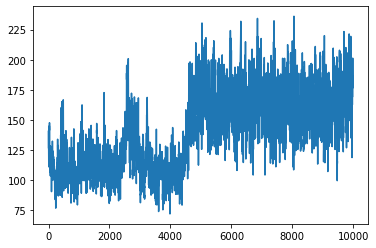

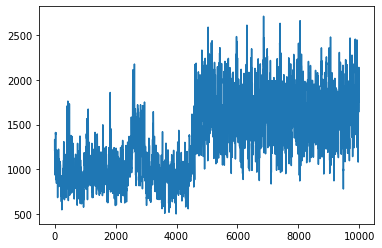

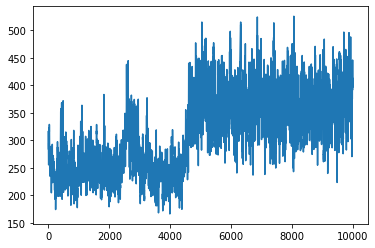

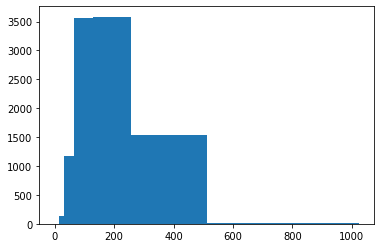

In [8]:
agent.show_information()

In [10]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)


In [1]:
def test(episodes):
        
    lengths, scores, endGameSums, maxCells = \
                       agent.game.getEpisodesData()
    plt.figure()
    plt.plot(running_mean(lengths, episodes))
    plt.figure()
    plt.plot(running_mean(scores, episodes))
    plt.figure()
    plt.plot(running_mean(endGameSums, episodes))
    plt.figure()
    plt.hist(maxCells, bins=[0, 8, 16, 32, 64, 128, 256, 512])
    
test(100)

NameError: name 'agent' is not defined

# Compute and print the running mean